# Projeto House Rocket Company

In [1]:
#https://www.kaggle.com/harlfoxem/housesalesprediction

# 0.0 Imports & Setup

## 0.1 Imports

In [2]:
import pandas as pd
import numpy as np
import inflection
import math
import seaborn as sns
import datetime
import matplotlib.gridspec as gridspec
import xgboost as xgb
import random
import pickle
import requests
from varname import nameof
#import warnings

#warnings.filterwarnings( 'ignore' )

from matplotlib import pyplot as plt
from tabulate import tabulate
from IPython.display import Image
from scipy import stats
from boruta import BorutaPy
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from skopt import BayesSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.model_selection import train_test_split, cross_val_score

## 0.2 Helper Functions

In [3]:
# Cramer com correção de viés
def cramer_v(x, y):
    
    tc = pd.crosstab(x, y).values
    n = tc.sum()
    r, k = tc.shape
    
    chi2 = stats.chi2_contingency(tc)[0]
    chi2_corrigido = max(0, chi2 - (k-1) * (r-1) / (n-1))
    k_corrigido = k - (k-1) **2 / (n-1)
    r_corrigido = r - (r-1) **2 / (n-1)
    
    return np.sqrt(chi2_corrigido/n / (min(k_corrigido-1, r_corrigido-1)))


def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y)


def log_mean_percentage_error(y, yhat):
    return np.mean((np.expm1(y) - np.expm1(yhat)) / np.expm1(y))
     
    
def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))


def log_mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((np.expm1(y) - np.expm1(yhat)) / np.expm1(y)))


def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse}, index=[0])


# prediction timeframe in days
def time_series_cross_validation(x_time_series, kfold, pred_timeframe, model_name, model, target_col, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    time_block = (x_time_series['date'].max() - x_time_series['date'].min() - datetime.timedelta( days=pred_timeframe)) / kfold
    start_date = x_time_series['date'].min()
    for k in range(1, kfold+1):
        if verbose:
            print('\nKFold Number: {}'.format(k))
        # end date for training
        end_date = start_date + time_block * k
        
        # filtering dataset
        train = x_time_series[x_time_series['date'] <= end_date]
        validation = x_time_series[x_time_series['date'] > end_date]
        
        x_train = train.drop(['date', target_col], axis=1)
        y_train = train[target_col]
        
        x_validation = validation.drop(['date', target_col], axis=1)
        y_validation = validation[target_col]
        
        # fitting
        m = model.fit(x_train, y_train )
        
        # prediction
        yhat = m.predict(x_validation)
        
        # performance
        m_result = ml_error(model_name,  y_validation ,  yhat)

        # store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name': model_name,
                          'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                          'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                          'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0])                


# prediction timeframe in days
def log_time_series_cross_validation(x_time_series, kfold, pred_timeframe, model_name, model, target_col, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    time_block = (x_time_series['date'].max() - x_time_series['date'].min() - datetime.timedelta(days=pred_timeframe)) / kfold
    start_date = x_time_series['date'].min()
    for k in range(1, kfold+1):
        if verbose:
            print('\nKFold Number: {}'.format(k))
        # end date for training
        end_date = start_date + time_block * k
        
        # filtering dataset
        train = x_time_series[x_time_series['date'] <= end_date]
        validation = x_time_series[x_time_series['date'] > end_date]
        
        x_train = train.drop(['date', target_col], axis=1)
        y_train = train[target_col]
        
        x_validation = validation.drop(['date', target_col], axis=1)
        y_validation = validation[target_col]
        
        # fitting
        m = model.fit(x_train, y_train)
        
        # prediction
        yhat = m.predict(x_validation)
        
        # performance
        m_result = ml_error(model_name,  np.expm1(y_validation) ,  np.expm1(yhat))

        # store performance of each kfold iteration
        mae_list.append(m_result['MAE'] )
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name': model_name,
                          'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                          'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                          'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0])     

 
# Meigarom's Algorithm (without using log)
def cross_validation(x_training, kfold, model_name, model, target_col, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1, kfold+1 )):
        if verbose:
            print('\nKFold Number: {}'.format(k))
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*3*30)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*3*30)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop(['date', target_col], axis=1) 
        ytraining = training[target_col]

        # validation
        xvalidation = validation.drop(['date', target_col], axis=1)
        yvalidation = validation[target_col]

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance *** USING EXPONENTIAL BECAUSE THE RESPONSE VARIABLE WAS TRANSFORMED BY LOG !!!
        m_result = ml_error(model_name, (yvalidation), (yhat))

        # store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name': model_name,
                          'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                          'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                          'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0])  


def log_cross_validation(x_training, kfold, model_name, model, target_col, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('\nKFold Number: {}'.format(k))
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*3*30)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*3*30)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop(['date', target_col], axis=1) 
        ytraining = training[target_col]

        # validation
        xvalidation = validation.drop(['date', target_col], axis=1)
        yvalidation = validation[target_col]

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance *** USING EXPONENTIAL BECAUSE THE RESPONSE VARIABLE WAS TRANSFORMED BY LOG !!!
        m_result = ml_error(model_name,  np.expm1(y_validation) ,  np.expm1(yhat))

        # store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name': model_name,
                          'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                          'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                          'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0])  

## 0.3 Global Settings

In [4]:
np.random.seed(0)

In [5]:
%matplotlib inline
%pylab inline

plt.style.use( 'bmh' )
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 24

#display( HTML( '<style>.container { width:100% !important; }</style>') )      nem sei o que faz,  mas só funcionou quando estava dentro de       def jupytyer_settings():
pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.set_option( 'display.expand_frame_repr', False )

sns.set()

sns.set_style('whitegrid')

Populating the interactive namespace from numpy and matplotlib


C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## 0.4 Loading Data

In [6]:
df1 = pd.read_csv('kc_house_data.csv')

# 1.0 Data Description

In [7]:
df1.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


## 1.1 Rename Columns

In [8]:
df1.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [9]:
df1.rename(columns={'yr_built': 'year_built', 'yr_renovated': 'year_renovated'}, inplace=True)

## 1.2 Data Dimensions

In [10]:
print('Number of Rows: {} \nNumber of Cols: {}' .format(df1.shape[0], df1.shape[1]))

Number of Rows: 21613 
Number of Cols: 21


## 1.3 Data Types

In [11]:
df1.dtypes

id                  int64
date               object
price             float64
bedrooms            int64
bathrooms         float64
sqft_living         int64
sqft_lot            int64
floors            float64
waterfront          int64
view                int64
condition           int64
grade               int64
sqft_above          int64
sqft_basement       int64
year_built          int64
year_renovated      int64
zipcode             int64
lat               float64
long              float64
sqft_living15       int64
sqft_lot15          int64
dtype: object

In [12]:
df1['floors'].unique()

array([1. , 2. , 1.5, 3. , 2.5, 3.5])

In [13]:
df1['date'] = pd.to_datetime(df1['date'])

## 1.4 Check NA

In [14]:
df1.isna().sum().sum()

0

## 1.5 Check Duplicates

In [15]:
df1.duplicated().sum()

0

## 1.6 Descriptive Statistics

In [16]:
print('The data starts on {} and ends on {}'.format(df1['date'].min(), df1['date'].max()))

The data starts on 2014-05-02 00:00:00 and ends on 2015-05-27 00:00:00


In [17]:
num_attributes = df1.drop(['id', 'zipcode'], axis=1).select_dtypes(include=['int64', 'float64'])
#cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]']) # não há atributos categóricos neste dataset

In [18]:
num_attributes.sample(2)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,year_built,year_renovated,lat,long,sqft_living15,sqft_lot15
17384,297000.0,2,1.50,1430,1650,3.0,0,0,3,7,1430,0,1999,0,47.7222,-122.290,1430,1650
722,1578000.0,4,3.25,4670,51836,2.0,0,0,4,12,4670,0,1988,0,47.6350,-122.164,4230,41075


### 1.6.1 Numerical Attributes

In [19]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
                  
# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,price,75000.0000,7.700000e+06,7.625000e+06,540088.141767,450000.0000,367118.703181,4.024069,34.585540
1,bedrooms,0.0000,3.300000e+01,3.300000e+01,3.370842,3.0000,0.930040,1.974300,49.063653
2,bathrooms,0.0000,8.000000e+00,8.000000e+00,2.114757,2.2500,0.770145,0.511108,1.279902
3,sqft_living,290.0000,1.354000e+04,1.325000e+04,2079.899736,1910.0000,918.419649,1.471555,5.243093
4,sqft_lot,520.0000,1.651359e+06,1.650839e+06,15106.967566,7618.0000,41419.553273,13.060019,285.077820
5,floors,1.0000,3.500000e+00,2.500000e+00,1.494309,1.5000,0.539976,0.616177,-0.484723
6,waterfront,0.0000,1.000000e+00,1.000000e+00,0.007542,0.0000,0.086515,11.385108,127.632494
7,view,0.0000,4.000000e+00,4.000000e+00,0.234303,0.0000,0.766300,3.395750,10.893022
8,condition,1.0000,5.000000e+00,4.000000e+00,3.409430,3.0000,0.650728,1.032805,0.525764
9,grade,1.0000,1.300000e+01,1.200000e+01,7.656873,7.0000,1.175432,0.771103,1.190932


In [20]:
num_attributes.describe().T

,count,mean,std,min,25%,50%,75%,max
price,21613.0,540088.141767,367127.196483,75000.0000,321950.000,450000.0000,645000.000,7.700000e+06
bedrooms,21613.0,3.370842,0.930062,0.0000,3.000,3.0000,4.000,3.300000e+01
bathrooms,21613.0,2.114757,0.770163,0.0000,1.750,2.2500,2.500,8.000000e+00
sqft_living,21613.0,2079.899736,918.440897,290.0000,1427.000,1910.0000,2550.000,1.354000e+04
sqft_lot,21613.0,15106.967566,41420.511515,520.0000,5040.000,7618.0000,10688.000,1.651359e+06
floors,21613.0,1.494309,0.539989,1.0000,1.000,1.5000,2.000,3.500000e+00
waterfront,21613.0,0.007542,0.086517,0.0000,0.000,0.0000,0.000,1.000000e+00
view,21613.0,0.234303,0.766318,0.0000,0.000,0.0000,0.000,4.000000e+00
condition,21613.0,3.409430,0.650743,1.0000,3.000,3.0000,4.000,5.000000e+00
grade,21613.0,7.656873,1.175459,1.0000,7.000,7.0000,8.000,1.300000e+01


In [21]:
# skew proximo de 0 indica que a distribuição é parecida com uma normal
# a kurtosis perto de 1 indica que tem um pico muito grande

# estudar sobre isso

C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


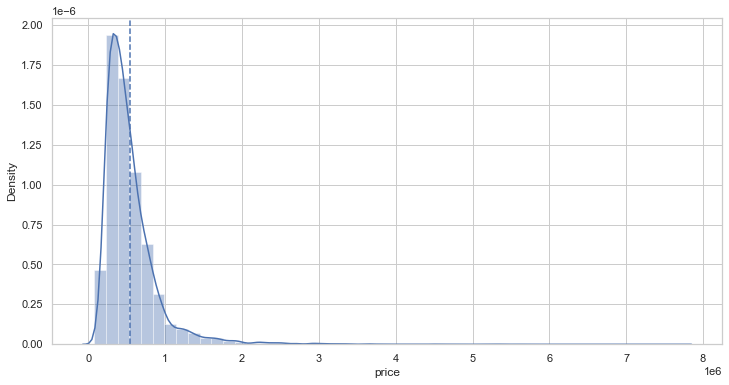

In [22]:
plt.figure(figsize=(12, 6))
sns.distplot(df1['price'])
plt.axvline(df1['price'].mean(), label='Mean', linestyle='--')
plt.show()

## 1.7 Check Outliers

In [23]:
df1.query('price <= 0')

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,year_built,year_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


In [24]:
df1.query('bedrooms > 9')

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,year_built,year_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8757,1773100755,2014-08-21,520000.0,11,3.00,3000,4960,2.0,0,0,3,7,2400,600,1918,1999,98106,47.5560,-122.363,1420,4960
13314,627300145,2014-08-14,1148000.0,10,5.25,4590,10920,1.0,0,2,3,9,2500,2090,2008,0,98004,47.5861,-122.113,2730,10400
15161,5566100170,2014-10-29,650000.0,10,2.00,3610,11914,2.0,0,0,4,7,3010,600,1958,0,98006,47.5705,-122.175,2040,11914
15870,2402100895,2014-06-25,640000.0,33,1.75,1620,6000,1.0,0,0,5,7,1040,580,1947,0,98103,47.6878,-122.331,1330,4700
19254,8812401450,2014-12-29,660000.0,10,3.00,2920,3745,2.0,0,0,4,7,1860,1060,1913,0,98105,47.6635,-122.320,1810,3745


In [25]:
df1.query('bedrooms > 10')
# the house with 33 bedrooms with not a huge sqft_living is suspicious, probably a typo

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,year_built,year_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8757,1773100755,2014-08-21,520000.0,11,3.00,3000,4960,2.0,0,0,3,7,2400,600,1918,1999,98106,47.5560,-122.363,1420,4960
15870,2402100895,2014-06-25,640000.0,33,1.75,1620,6000,1.0,0,0,5,7,1040,580,1947,0,98103,47.6878,-122.331,1330,4700


In [26]:
df1.drop(df1.index[15870], inplace=True)

In [27]:
df1.query('price > 5000000')

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,year_built,year_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1164,1247600105,2014-10-20,5110800.0,5,5.25,8010,45517,2.0,1,4,3,12,5990,2020,1999,0,98033,47.6767,-122.211,3430,26788
1315,7558700030,2015-04-13,5300000.0,6,6.00,7390,24829,2.0,1,4,4,12,5000,2390,1991,0,98040,47.5631,-122.210,4320,24619
1448,8907500070,2015-04-13,5350000.0,5,5.00,8000,23985,2.0,0,4,3,12,6720,1280,2009,0,98004,47.6232,-122.220,4600,21750
3914,9808700762,2014-06-11,7062500.0,5,4.50,10040,37325,2.0,1,2,3,11,7680,2360,1940,2001,98004,47.6500,-122.214,3930,25449
4411,2470100110,2014-08-04,5570000.0,5,5.75,9200,35069,2.0,0,0,3,13,6200,3000,2001,0,98039,47.6289,-122.233,3560,24345
7252,6762700020,2014-10-13,7700000.0,6,8.00,12050,27600,2.5,0,3,4,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800
9254,9208900037,2014-09-19,6885000.0,6,7.75,9890,31374,2.0,0,4,3,13,8860,1030,2001,0,98039,47.6305,-122.240,4540,42730


In [28]:
df1.query('bedrooms < 1')

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,year_built,year_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
875,6306400140,2014-06-12,1095000.0,0,0.00,3064,4764,3.5,0,2,3,7,3064,0,1990,0,98102,47.6362,-122.322,2360,4000
3119,3918400017,2015-02-05,380000.0,0,0.00,1470,979,3.0,0,2,3,8,1470,0,2006,0,98133,47.7145,-122.356,1470,1399
3467,1453602309,2014-08-05,288000.0,0,1.50,1430,1650,3.0,0,0,3,7,1430,0,1999,0,98125,47.7222,-122.290,1430,1650
4868,6896300380,2014-10-02,228000.0,0,1.00,390,5900,1.0,0,0,2,4,390,0,1953,0,98118,47.5260,-122.261,2170,6000
6994,2954400190,2014-06-24,1295650.0,0,0.00,4810,28008,2.0,0,0,3,12,4810,0,1990,0,98053,47.6642,-122.069,4740,35061
8477,2569500210,2014-11-17,339950.0,0,2.50,2290,8319,2.0,0,0,3,8,2290,0,1985,0,98042,47.3473,-122.151,2500,8751
8484,2310060040,2014-09-25,240000.0,0,2.50,1810,5669,2.0,0,0,3,7,1810,0,2003,0,98038,47.3493,-122.053,1810,5685
9773,3374500520,2015-04-29,355000.0,0,0.00,2460,8049,2.0,0,0,3,8,2460,0,1990,0,98031,47.4095,-122.168,2520,8050
9854,7849202190,2014-12-23,235000.0,0,0.00,1470,4800,2.0,0,0,3,7,1470,0,1996,0,98065,47.5265,-121.828,1060,7200
12653,7849202299,2015-02-18,320000.0,0,2.50,1490,7111,2.0,0,0,3,7,1490,0,1999,0,98065,47.5261,-121.826,1500,4675


In [29]:
len(df1.query('bathrooms < 1'))

86

In [30]:
len(df1.query('year_renovated < 1900'))
# 20699 houses weren't renovated anytime since they were built

20698

In [31]:
df1.bedrooms.value_counts().sort_index()

0       13
1      199
2     2760
3     9824
4     6882
5     1601
6      272
7       38
8       13
9        6
10       3
11       1
Name: bedrooms, dtype: int64

In [32]:
len(df1.query('bedrooms == 5'))

1601

C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


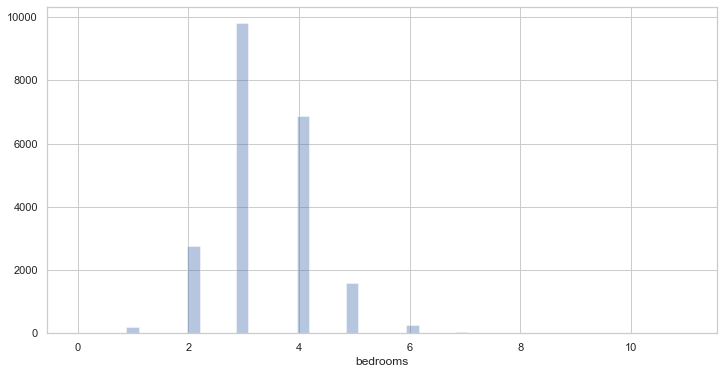

In [33]:
sns.distplot(df1.bedrooms, hist=True, kde=False);

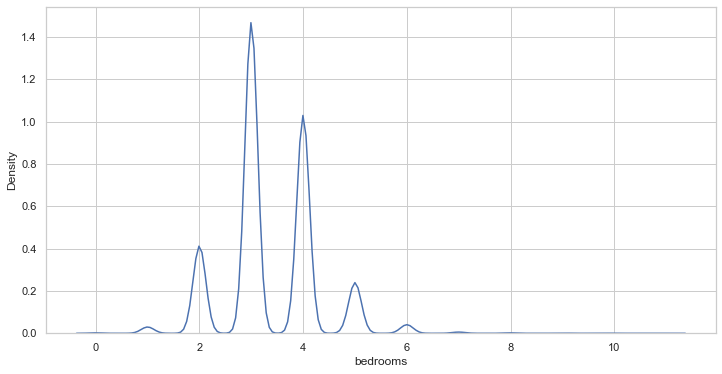

In [34]:
sns.kdeplot(df1.bedrooms);

In [35]:
df1.bathrooms.value_counts().sort_index()

0.00      10
0.50       4
0.75      72
1.00    3852
1.25       9
1.50    1446
1.75    3047
2.00    1930
2.25    2047
2.50    5380
2.75    1185
3.00     753
3.25     589
3.50     731
3.75     155
4.00     136
4.25      79
4.50     100
4.75      23
5.00      21
5.25      13
5.50      10
5.75       4
6.00       6
6.25       2
6.50       2
6.75       2
7.50       1
7.75       1
8.00       2
Name: bathrooms, dtype: int64

# 2.0 Feature Engineering

In [36]:
df2 = df1.copy()

## 2.1 Hypothesis Mental Map

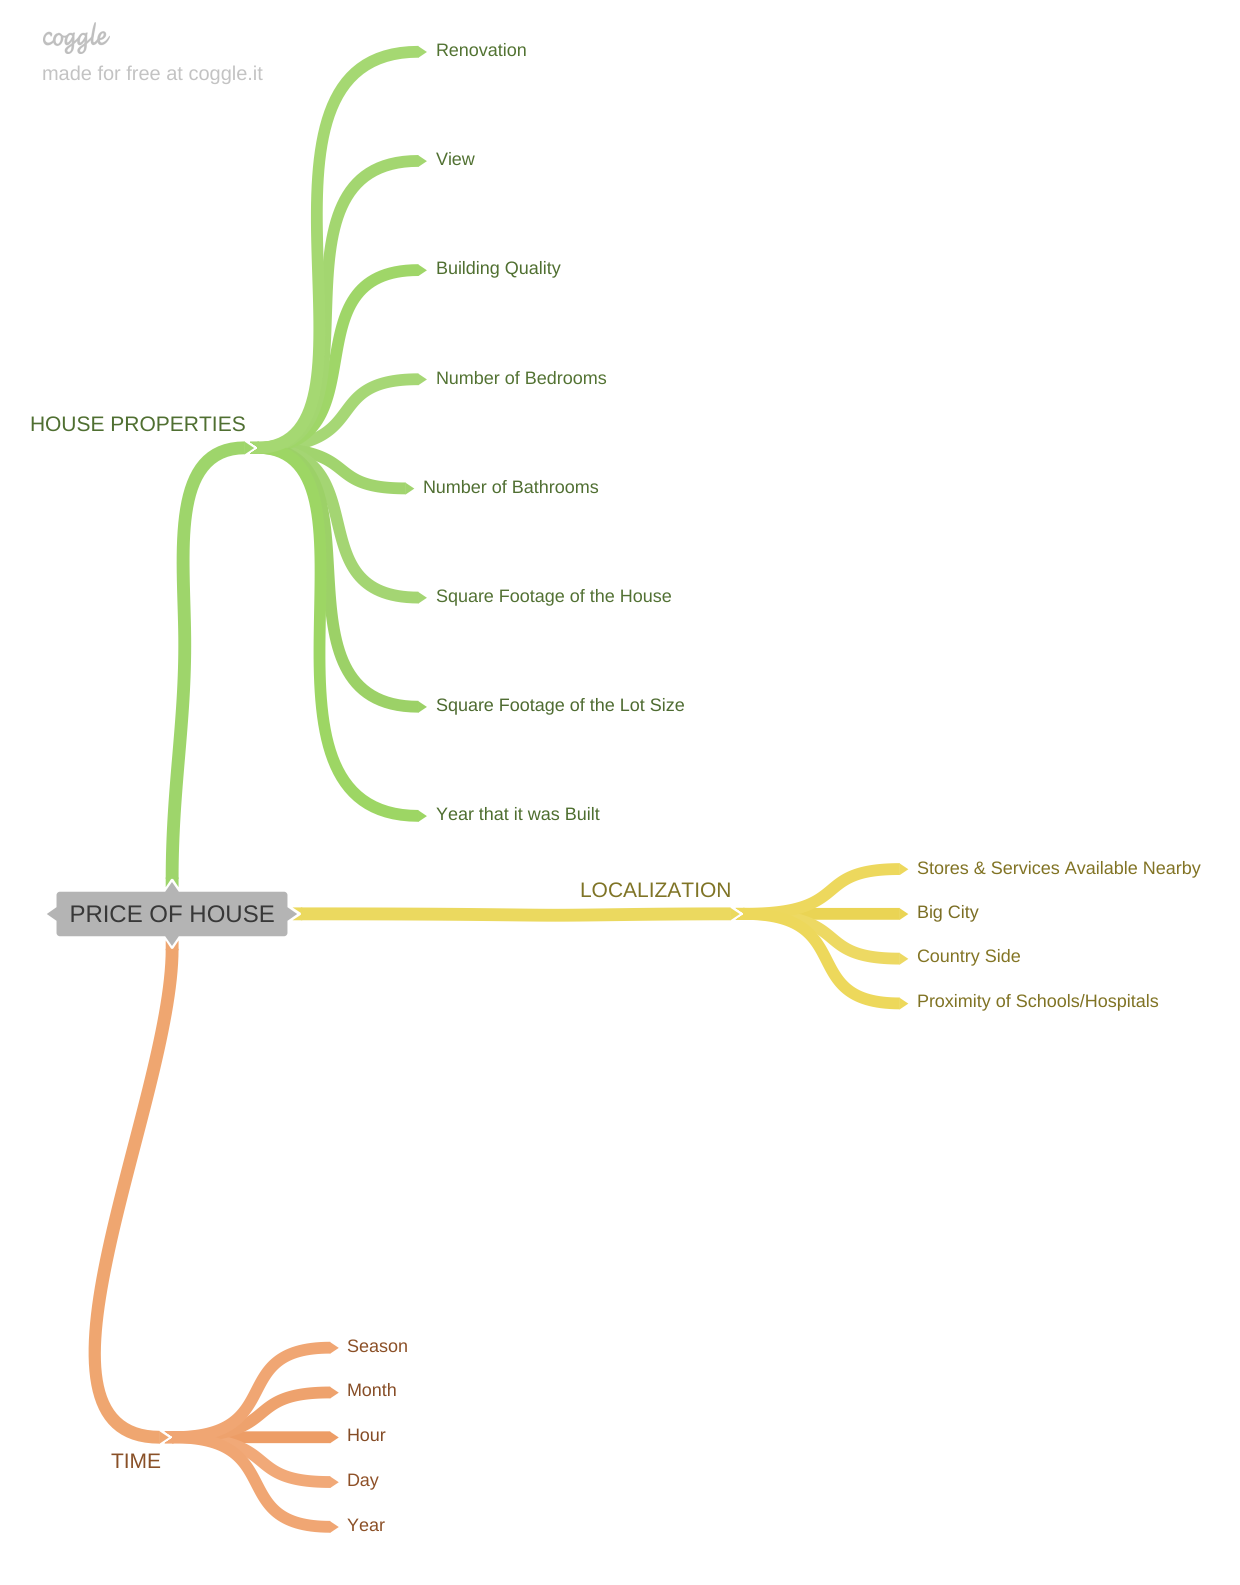

In [37]:
Image('price_of_house_mind_map_hypothesis.png')

## 2.2 Hypothesis Generation

### 2.2.1 House Properties Hypothesis

1. Houses with more Bedrooms are MORE EXPENSIVE
2. Houses with more Bathrooms are MORE EXPENSIVE
3. Houses with a Higher Quality Building are MORE EXPENSIVE
4. Houses with a better View are MORE EXPENSIVE
5. Bigger Houses are MORE EXPENSIVE
6. Houses with bigger Areas are MORE EXPENSIVE
7. Older Houses are CHEAPER
8. Renovated Houses are MORE EXPENSIVE
9. Houses that were Renovated recently are MORE EXPENSIVE

### 2.2.2 Localization Hypothesis

1. Houses in Big City are MORE EXPENSIVE than Houses in the Country Side
2. Houses with more Stores and Services nearby ARE MORE EXPENSIVE

### 2.2.3 Time Hypothesis

1. There are MORE Houses sold during the weekend

2. MORE Houses are sold during the Summer and Spring

## 2.3 Hypothesis Final List

In [38]:
# priorize hypothesis to later use in the Exploratory Data Analysis

1. Houses with more Bedrooms are MORE EXPENSIVE
2. Houses with more Bathrooms are MORE EXPENSIVE
3. Houses with a Higher Quality Building are MORE EXPENSIVE
4. Houses with a better View are MORE EXPENSIVE
5. Bigger Houses are MORE EXPENSIVE
6. Houses with bigger Areas are MORE EXPENSIVE
7. Older Houses are CHEAPER
8. Renovated Houses are MORE EXPENSIVE
9. Houses that were Renovated recently are MORE EXPENSIVE
10. There are MORE Houses sold during the weekend

## 2.4 Feature Engineering

In [39]:
df2.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'year_built', 'year_renovated',
       'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [40]:
df2['sqft_non_living'] = df2['sqft_lot'] - df2['sqft_living']
df2[['sqft_living', 'sqft_lot', 'sqft_non_living']].head()

,sqft_living,sqft_lot,sqft_non_living
0,1180,5650,4470
1,2570,7242,4672
2,770,10000,9230
3,1960,5000,3040
4,1680,8080,6400


In [41]:
# extract date columns

df2['day'] = df2['date'].dt.day

df2['month'] = df2['date'].dt.month

df2['year'] = df2['date'].dt.year

df2['week_of_year'] = df2['date'].dt.weekofyear

df2['day_of_week'] = df2['date'].dt.dayofweek # 0 is Monday, up to 6 --> Sunday

df2.sample(5).T

,5633,16322,333,5932,7520
id,3424069145,1972200725,9550201550,7625704317,1049000740
date,2014-09-25 00:00:00,2015-04-07 00:00:00,2015-04-08 00:00:00,2015-05-03 00:00:00,2014-11-20 00:00:00
price,343000,620000,640000,377500,229950
bedrooms,3,3,2,2,2
bathrooms,1,2.5,1,1,1.5
sqft_living,1400,1776,1070,840,1160
sqft_lot,5662,1248,5000,4500,1848
floors,1.5,3,1,1,2
waterfront,0,0,0,0,0
view,0,0,0,0,0


In [42]:
# week_of_year --> 1 up to 52 (no years in this data had 53 weeks) (2014 nor 2015)
def season(week_of_year):
    if week_of_year >= 10 and week_of_year < 23:
        week_of_year = 'Spring'
    elif week_of_year >= 23 and week_of_year < 36:
        week_of_year = 'Summer'
    elif week_of_year >= 36 and week_of_year < 49:
        week_of_year = 'Fall'
    else:
        week_of_year = 'Winter'
        
    return week_of_year
        
df2['season'] = df2['week_of_year'].apply(season)

In [43]:
df2[['date', 'week_of_year', 'season']].tail(5)

,date,week_of_year,season
21608,2014-05-21,21,Spring
21609,2015-02-23,9,Winter
21610,2014-06-23,26,Summer
21611,2015-01-16,3,Winter
21612,2014-10-15,42,Fall


# 3.0 Variables Filtering

In [44]:
df3 = df2.copy()

## 3.1 Rows Filtering

In [45]:
# filtering outliers

df3_without_outliers = df3.drop(df3[(df3['bathrooms'] < 1) | (df3['bedrooms'] < 1)].index)
# 91 lines dropped

## 3.2 Columns Selection

# 4.0 Exploratory Data Analysis

## 4.1 Univariable Analysis

### 4.1.1 Response Variable

C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


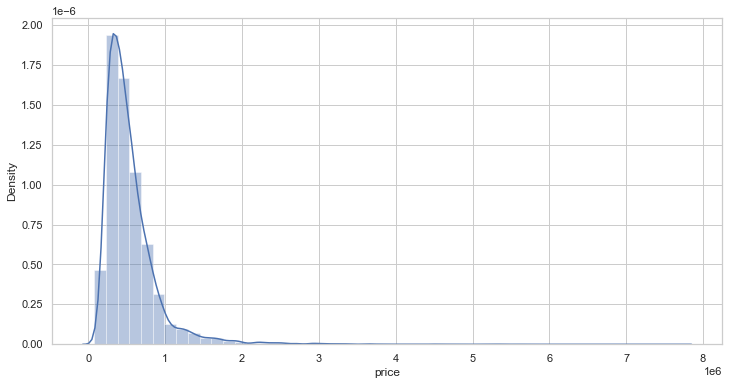

In [46]:
sns.distplot(df3['price']);

C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


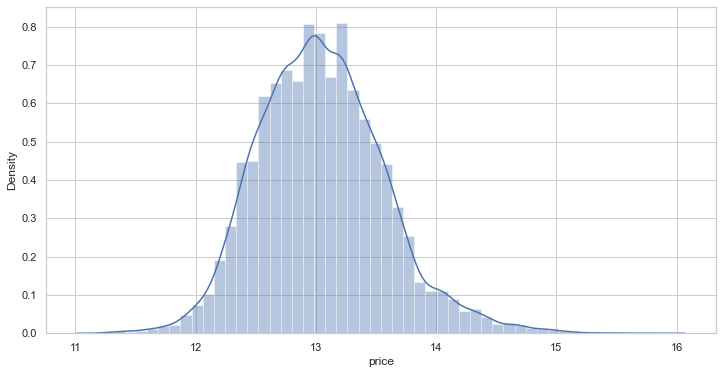

In [47]:
sns.distplot(np.log1p(df3['price']));
# applying log makes the distribution of price really looks like a normal dist

### 4.1.2 Numerical Variables

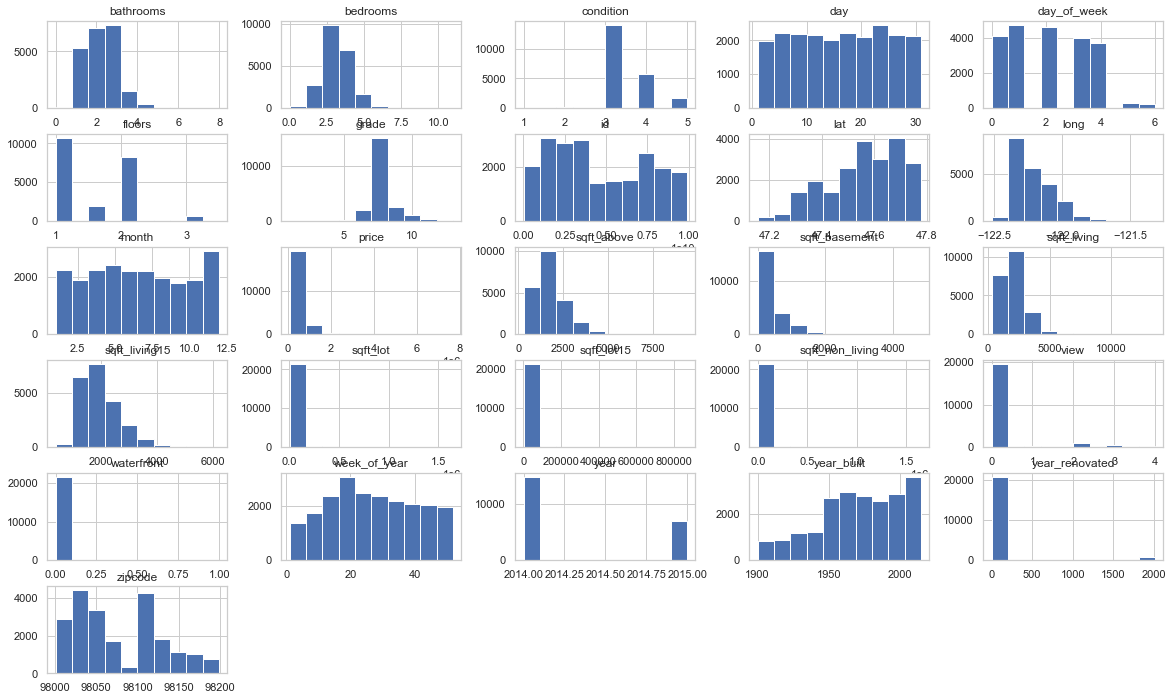

In [48]:
df3.hist(figsize=(20,12));

In [49]:
print(len(df3.query('waterfront == 0')))
print(len(df3.query('waterfront == 1')))

21449
163


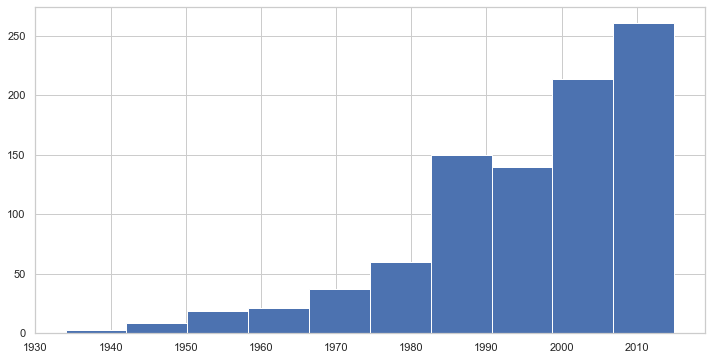

In [50]:
df3[df3['year_renovated'] > 0]['year_renovated'].hist();

## 4.2 Bivariable Analysis

### 4.2.1 **Hypothesis** 1 - Houses with more Bedrooms are MORE EXPENSIVE
- ***True up to a certain number of bedrooms (in this case, 8)*** - for some motive, houses with more than 8 bedrooms tend to be a bit cheaper than houses with 7-8 bedrooms, maybe because they tend to be smaller (just a guess)

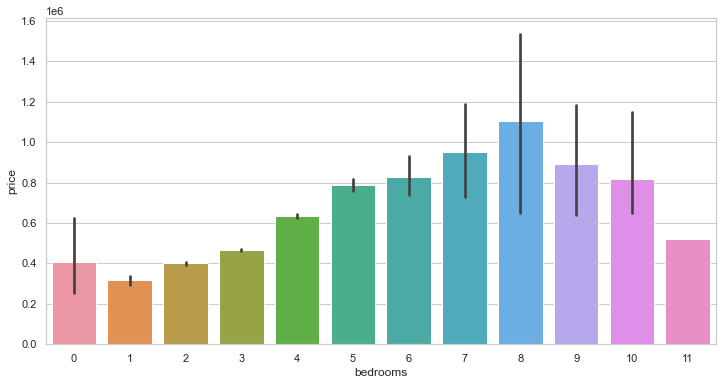

In [51]:
sns.barplot(data=df3, x='bedrooms', y='price', estimator=mean);

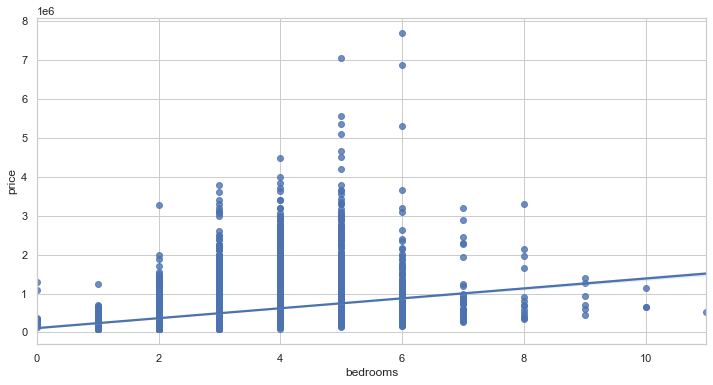

In [52]:
sns.regplot(data = df3, x='bedrooms', y='price');

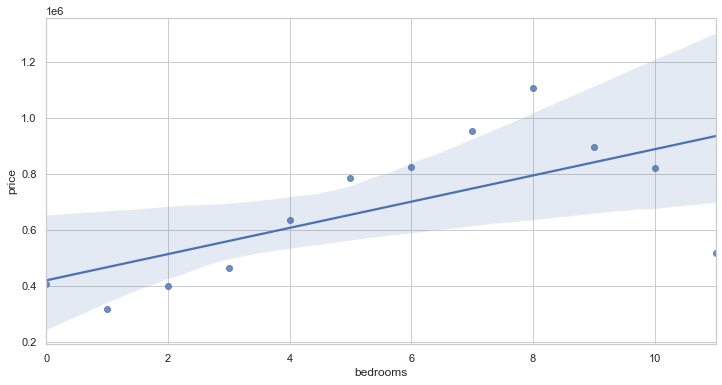

In [53]:
aux1 = df3[['bedrooms', 'price']].groupby('bedrooms').mean().reset_index()
sns.regplot(x='bedrooms', y='price', data=aux1);

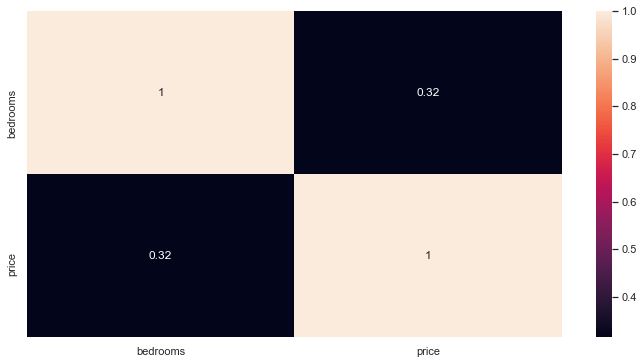

In [54]:
sns.heatmap(df3[['bedrooms', 'price']].corr(), annot=True);

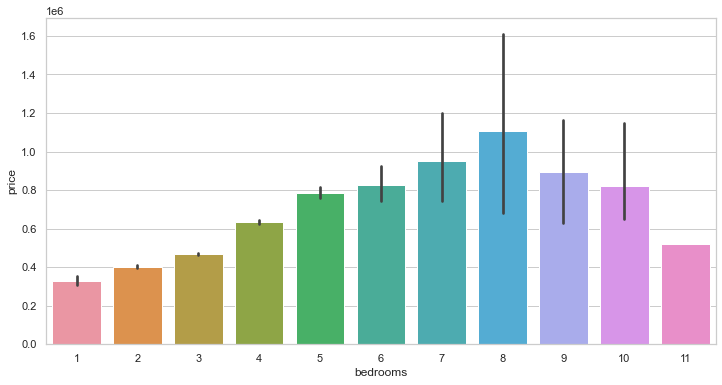

In [55]:
sns.barplot(data=df3_without_outliers, x='bedrooms', y='price', estimator=mean);

### 4.2.2 **Hypothesis** 2 - Houses with more Bathrooms are MORE EXPENSIVE
- ***True*** - although it isn't a straight upward increase

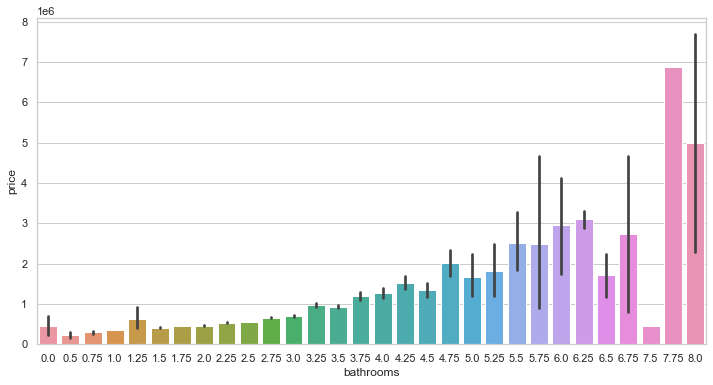

In [56]:
sns.barplot(data=df3, x='bathrooms', y='price');

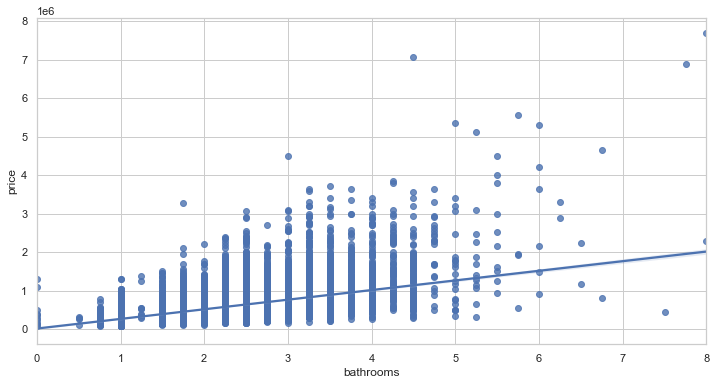

In [57]:
sns.regplot(data=df3, x='bathrooms', y='price');

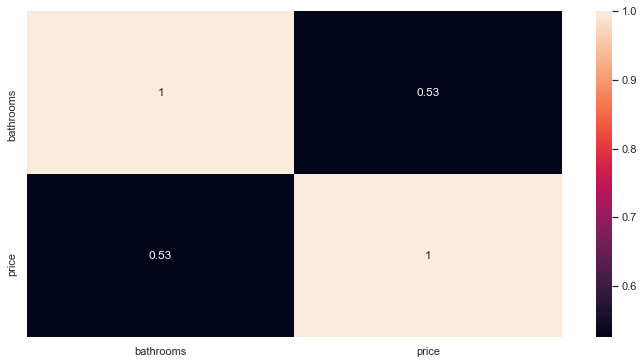

In [58]:
sns.heatmap(data=df3[['bathrooms', 'price']].corr(), annot=True);

### 4.2.3 **Hypothesis 3** - Houses with a Higher Quality Building are MORE EXPENSIVE
- ***True***

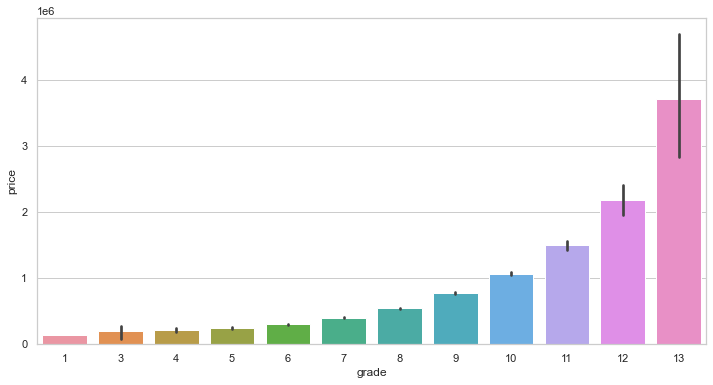

In [59]:
sns.barplot(data=df3, x='grade', y='price');

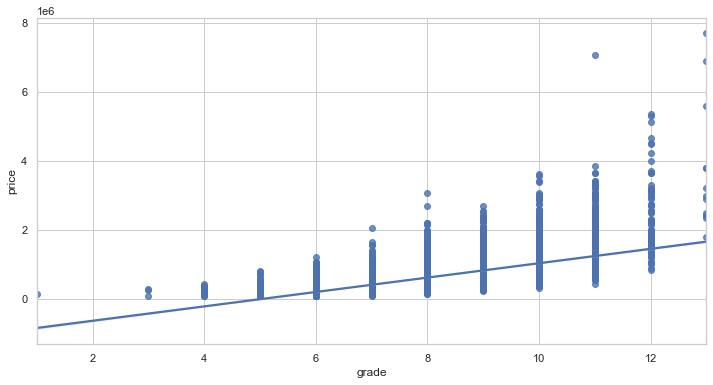

In [60]:
sns.regplot(data=df3, x='grade', y='price');

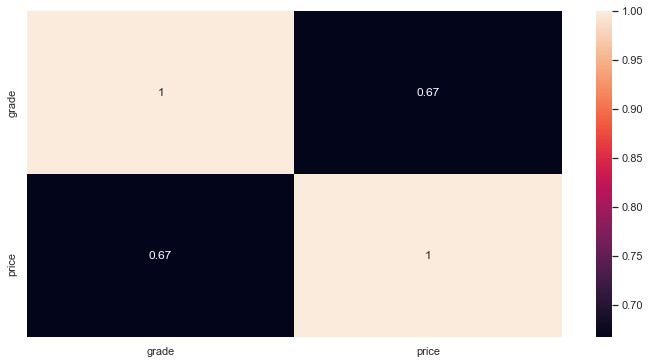

In [61]:
sns.heatmap(data=df3[['grade', 'price']].corr(method='pearson'), annot=True);
#sns.heatmap(data=aux1.corr(method='pearson'), annot=True);

### 4.2.4 **Hypothesis 4** - Houses with a better View are MORE EXPENSIVE
- ***True***

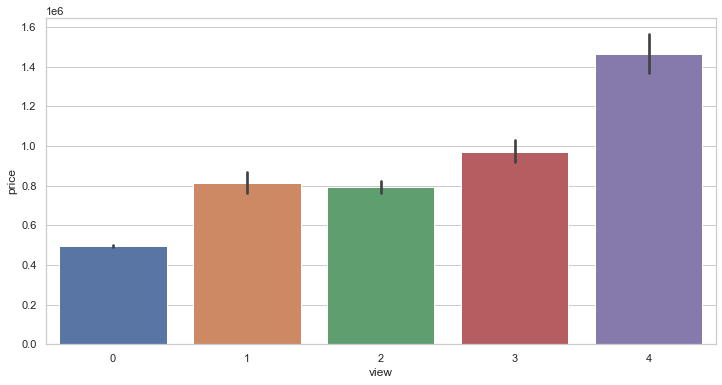

In [62]:
sns.barplot(x='view', y='price', data=df3);

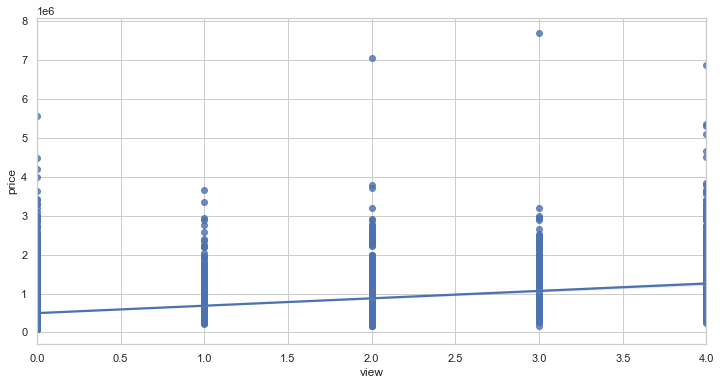

In [63]:
sns.regplot(x='view', y='price', data=df3);

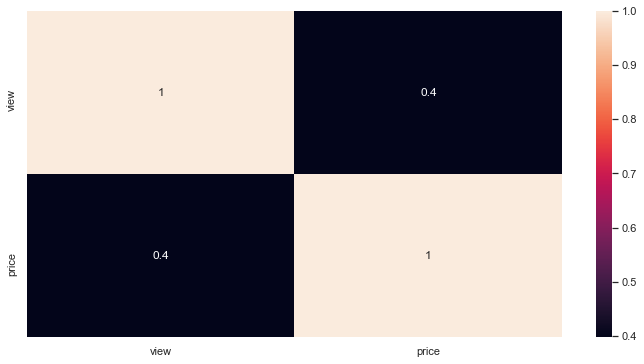

In [64]:
sns.heatmap(data=df3[['view', 'price']].corr(), annot=True);

### 4.2.5 **Hypothesis 5** - Bigger Houses are MORE EXPENSIVE
- ***True***

C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


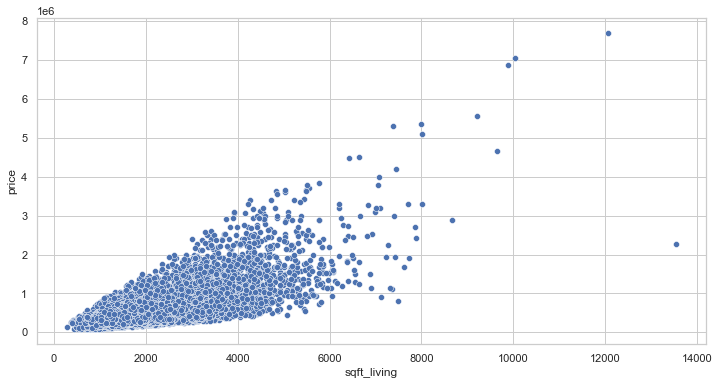

In [65]:
sns.scatterplot('sqft_living', 'price', data=df3);

C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


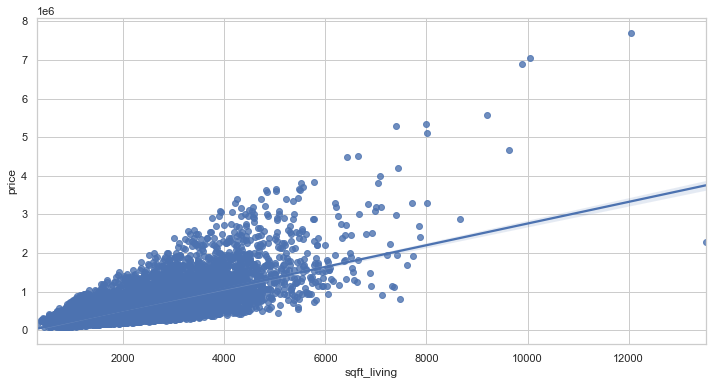

In [66]:
sns.regplot('sqft_living', 'price', data=df3);

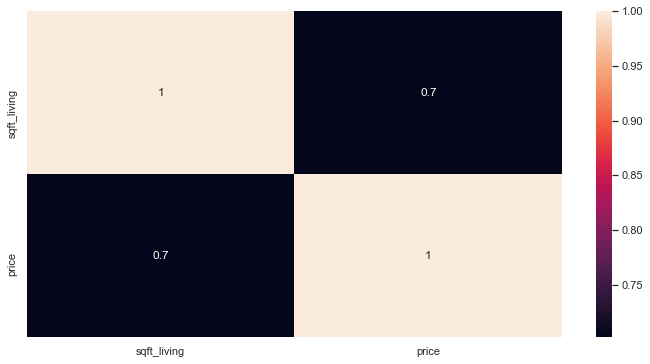

In [67]:
sns.heatmap(data=df3[['sqft_living', 'price']].corr(), annot=True);

### 4.2.6 **Hypothesis 6** - Houses with bigger Areas are MORE EXPENSIVE
- ***True, but*** - there is a small positive correlation (a higher was expected). It may be related to something like: houses with bigger areas tend to be in the Country Side, so they are less expensive due to this fact. House with small areas are probably in big cities, thus, they cost way more per sqft.

C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


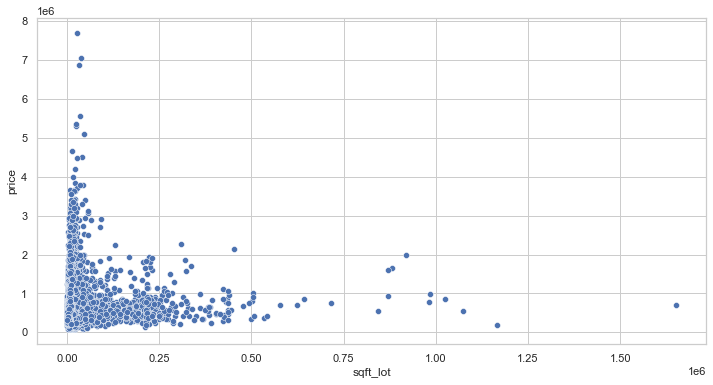

In [68]:
sns.scatterplot('sqft_lot', 'price', data=df3);

C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


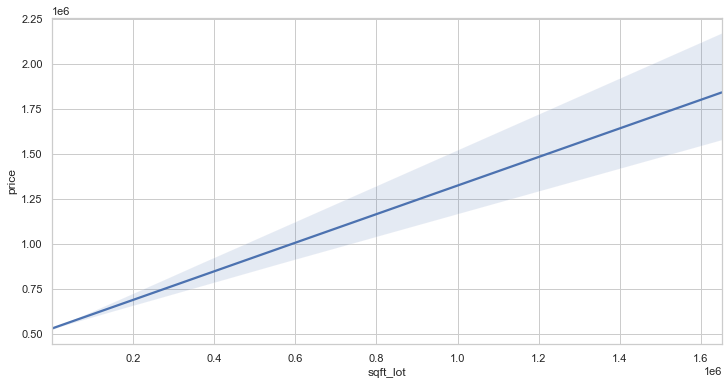

In [69]:
sns.regplot('sqft_lot', 'price', data=df3, scatter=False);

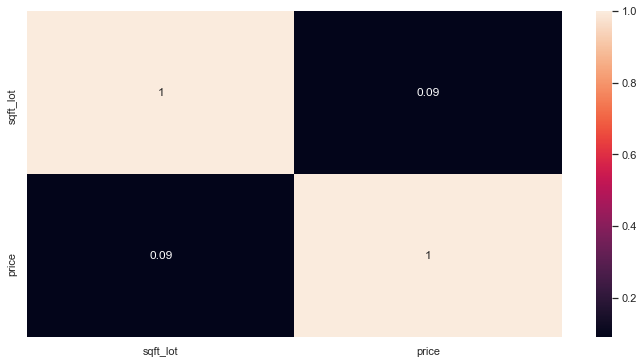

In [70]:
sns.heatmap(data=df3[['sqft_lot', 'price']].corr(), annot=True);

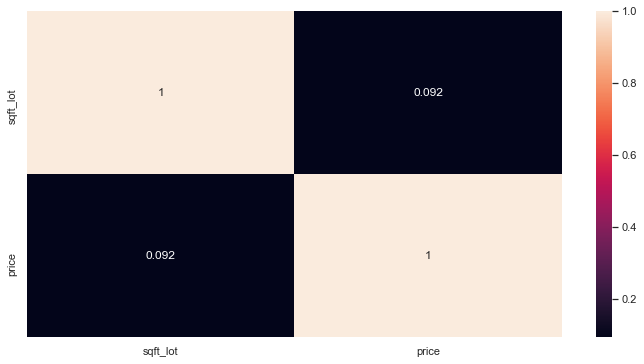

In [71]:
aux = df3[df3['sqft_lot'] < 750000]
sns.heatmap(data=aux[['sqft_lot', 'price']].corr(), annot=True);

### 4.2.7 **Hypothesis 7** - Older Houses are CHEAPER
- ***Kind of False*** - There is a positive correlation. but it's really small, it seems almost constant

C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


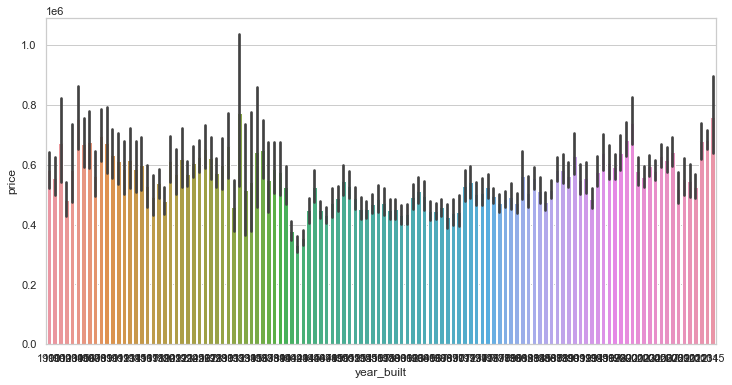

In [72]:
sns.barplot('year_built', 'price', data=df3);

C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


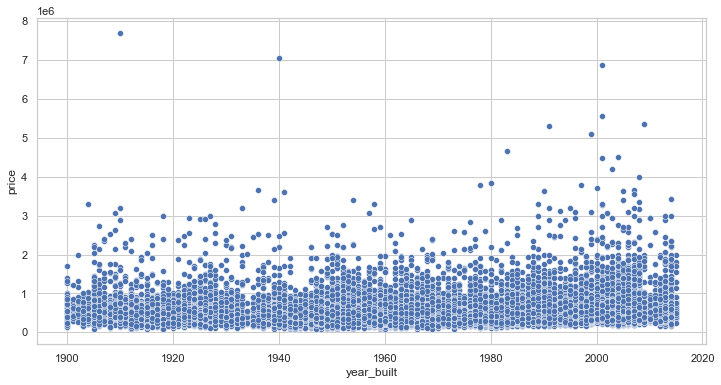

In [73]:
sns.scatterplot('year_built', 'price', data=df3);

C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


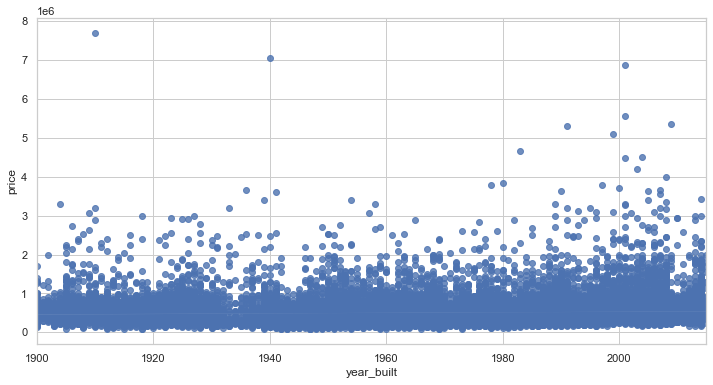

In [74]:
sns.regplot('year_built', 'price', data=df3);

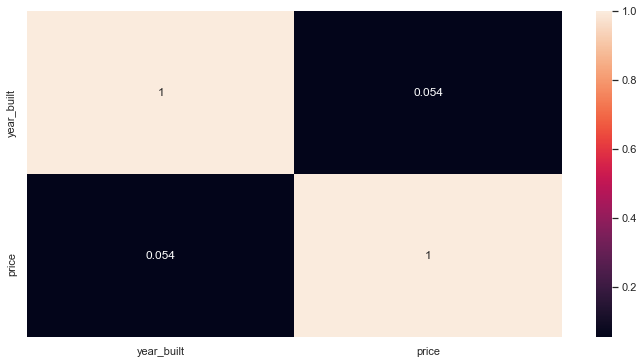

In [75]:
sns.heatmap(data=df3[['year_built', 'price']].corr(), annot=True);

### 4.2.8 **Hypothesis 8** - Renovated Houses are MORE EXPENSIVE
- ***True***

C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


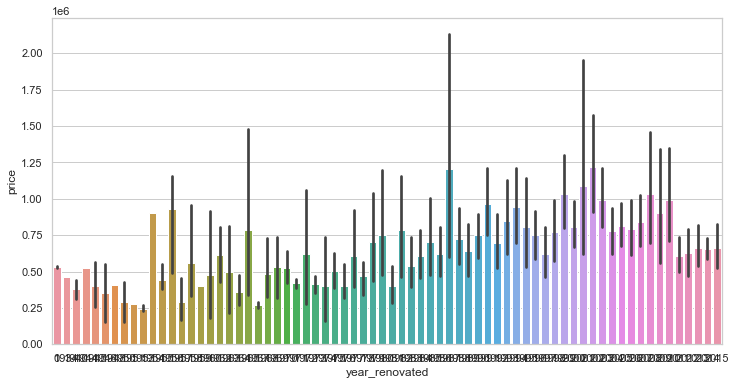

In [76]:
sns.barplot('year_renovated', 'price', data=df3);

C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


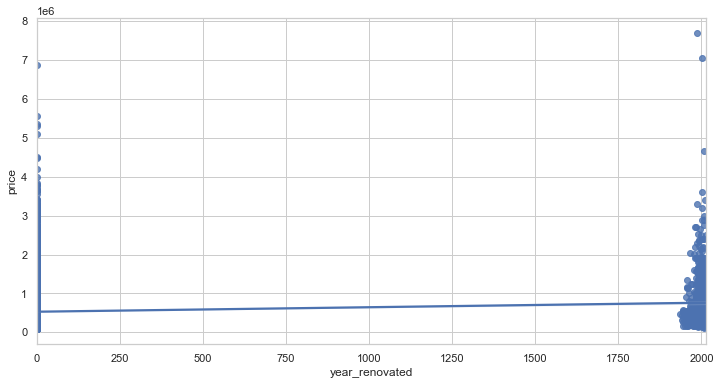

In [77]:
sns.regplot('year_renovated', 'price', data=df3);

C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


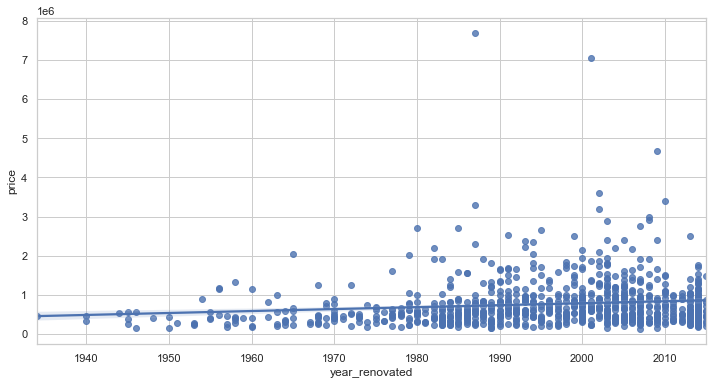

In [78]:
# plotting only houses that were renovated
renovated = df3[df3['year_renovated'] > 0]
sns.regplot('year_renovated', 'price', data=renovated);

In [79]:
renovated = df3[df3['year_renovated'] > 0]
not_renovated = df3[df3['year_renovated'] == 0]

In [80]:
print('Mean Price of Houses that were renovated: {}'.format(renovated['price'].mean()))
print('Mean Price of Houses that were NOT renovated: {}'.format(df3[df3['year_renovated'] == 0]['price'].mean()))
print('Mean Price of all Houses: {}'.format(df3['price'].mean()))

Mean Price of Houses that were renovated: 760379.0295404814
Mean Price of Houses that were NOT renovated: 530355.5210648372
Mean Price of all Houses: 540083.5187858597


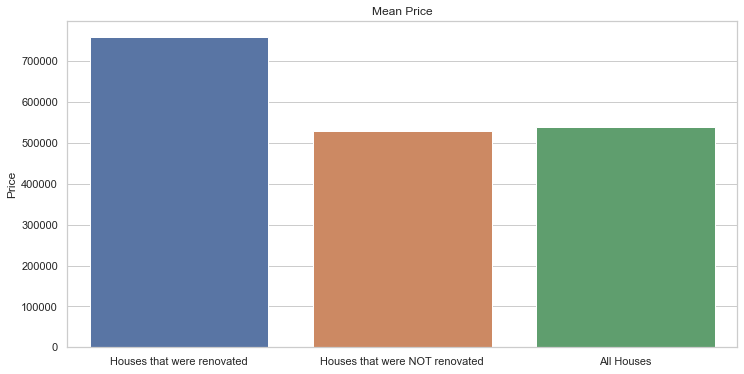

In [81]:
sns.barplot(x=['Houses that were renovated', 'Houses that were NOT renovated', 'All Houses'], y=[renovated['price'].mean(), not_renovated['price'].mean(), df3['price'].mean()]);
plt.title('Mean Price');
plt.ylabel('Price');

In [82]:
len(renovated)

914

In [83]:
len(not_renovated)

20698

### 4.2.9 **Hypothesis 9** - Houses that were Renovated recently are MORE EXPENSIVE
- ***True***

C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


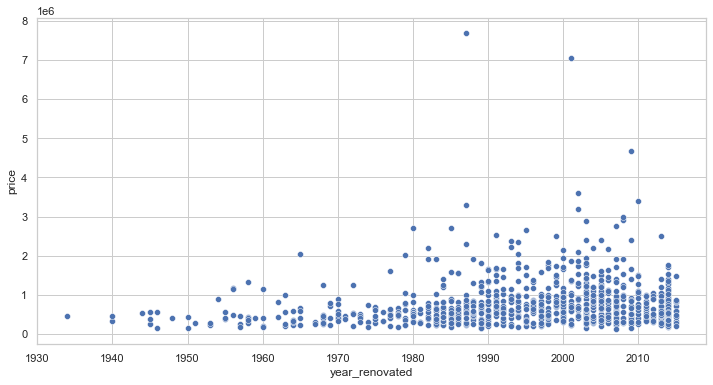

In [84]:
sns.scatterplot('year_renovated', 'price', data=renovated);

C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


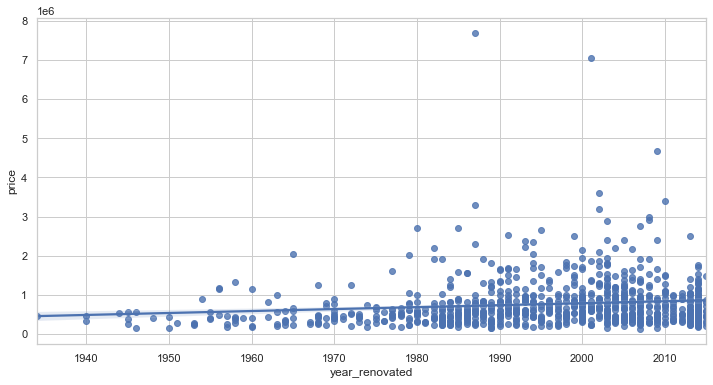

In [85]:
sns.regplot('year_renovated', 'price', data=renovated);

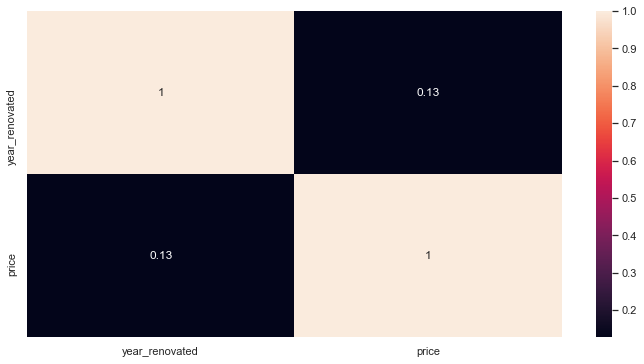

In [86]:
sns.heatmap(data=renovated[['year_renovated', 'price']].corr(), annot=True);

### 4.2.10 **Hypothesis 10** - Houses in a better Condition are MORE EXPENSIVE
- ***True***

C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


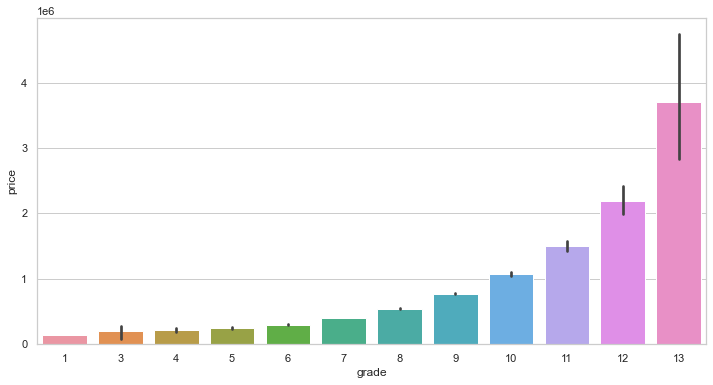

In [87]:
sns.barplot('grade', 'price', data=df3);

C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


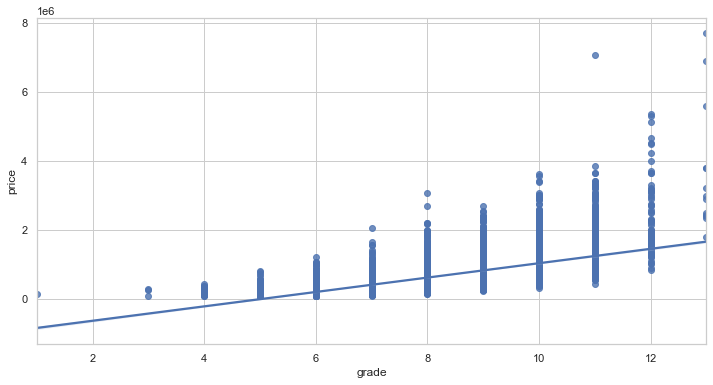

In [88]:
sns.regplot('grade', 'price', data=df3);

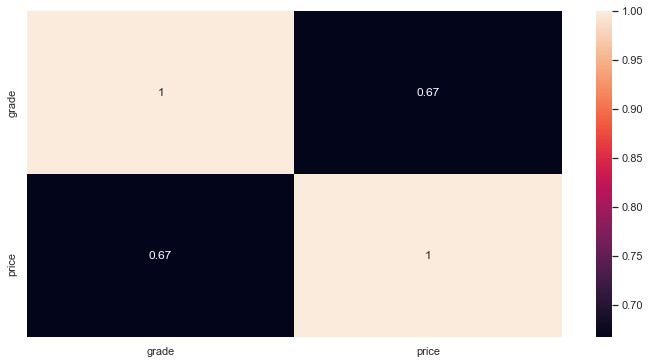

In [89]:
sns.heatmap(data=df3[['grade', 'price']].corr(method='pearson'), annot=True);

### 4.2.11 **Hypothesis 11** - Houses that area Waterfront are MORE EXPENSIVE
- ***True***

C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


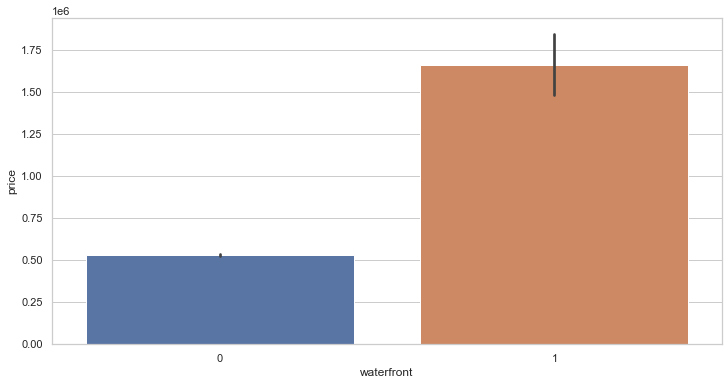

In [90]:
sns.barplot('waterfront', 'price', data=df3);

### 4.2.12 **Hypothesis 12** -  There are MORE Houses sold during the weekend
- ***False*** - There are way LESS Houses sold during the weekend

Insights:
- There are way LESS Houses sold during the weekend
- the first weeks of the year tend to sell LESS, which includes January and February
- Excluding Jan and Feb, the last 2 months sell LESS (November and December)
- Fall sell way LESS than Summer and Spring, and Winter sell way less then Fall

C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


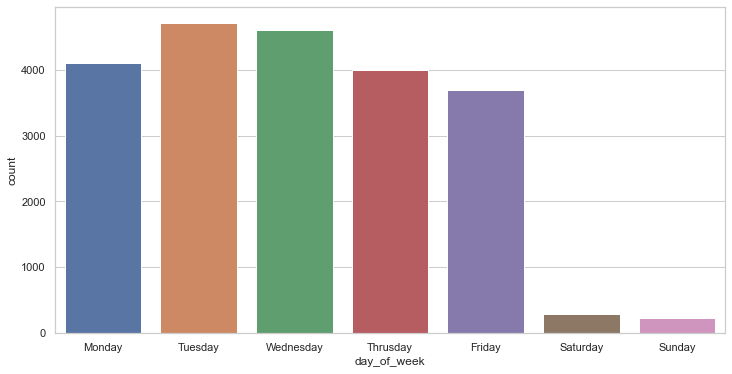

In [91]:
sns.countplot('day_of_week', data=df3);
plt.xticks([0, 1, 2, 3, 4, 5, 6], labels=['Monday', 'Tuesday', 'Wednesday', 'Thrusday', 'Friday', 'Saturday', 'Sunday']);

C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


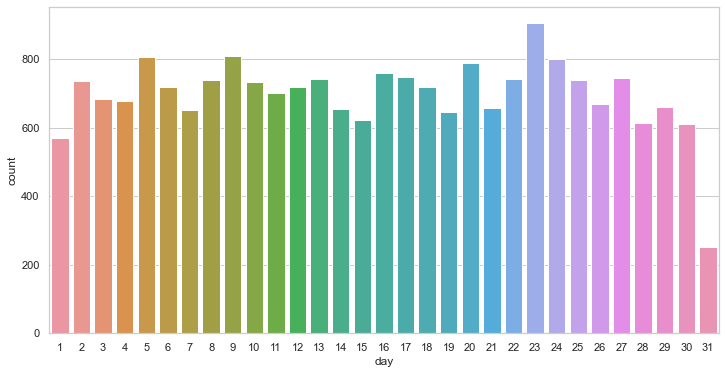

In [92]:
sns.countplot('day', data=df3);

C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


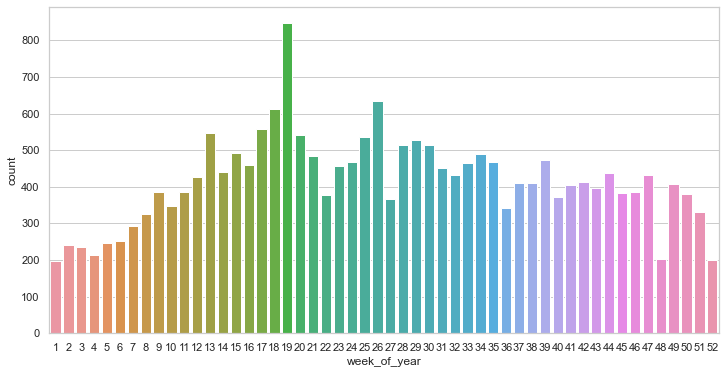

In [93]:
sns.countplot('week_of_year', data=df3);

C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


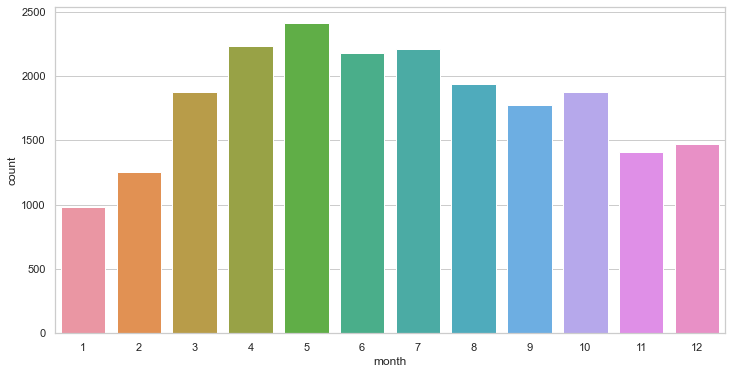

In [94]:
sns.countplot('month', data=df3);

C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


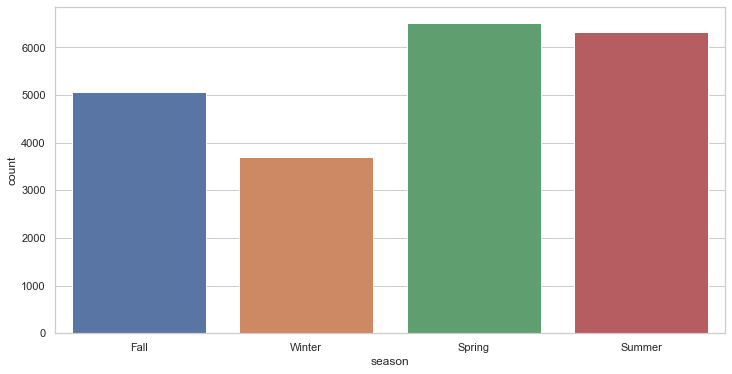

In [95]:
sns.countplot('season', data=df3);

C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


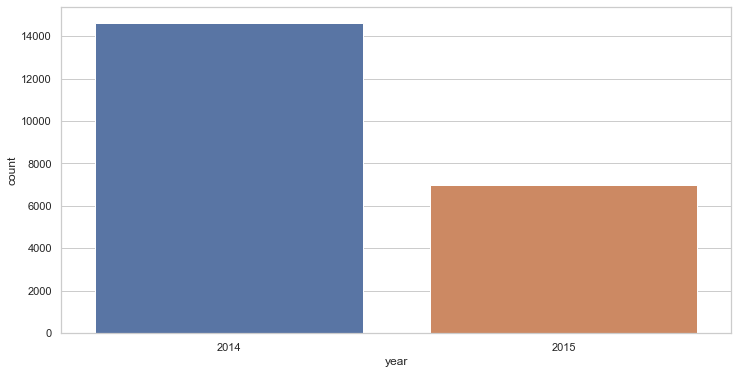

In [96]:
sns.countplot('year', data=df3);
# we only have data until 27th may 2015

### 4.2.13 **Hypothesis 13** -  The Houses sold during the weekend are MORE EXPENSIVE
- ***False*** - The sales' price is equally distributed between:
- the days of the week and weekend
- the days of the month
- the weeks of year
- the months
- the seasons
- the years

Day of Week

C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


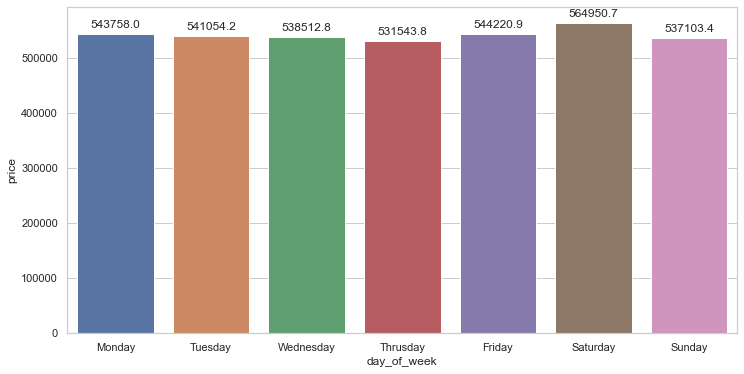

In [97]:
# 0 is Monday, 1 is Tuesday, 2 is Wednesday, 3 is Thrusday, 4 is Friday, 5 is Saturday, 6 is Sunday
splot = sns.barplot('day_of_week', 'price', data=df3, ci=None, estimator=mean);

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
plt.xticks([0, 1, 2, 3, 4, 5, 6], labels=['Monday', 'Tuesday', 'Wednesday', 'Thrusday', 'Friday', 'Saturday', 'Sunday']);

C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


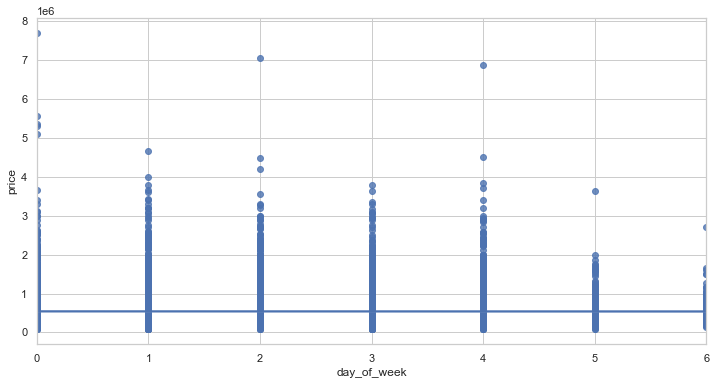

In [98]:
sns.regplot('day_of_week', 'price', data=df3);

C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


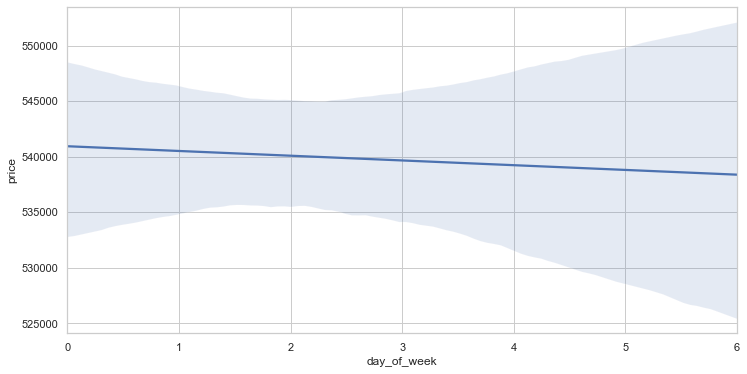

In [99]:
sns.regplot('day_of_week', 'price', data=df3, scatter=False);

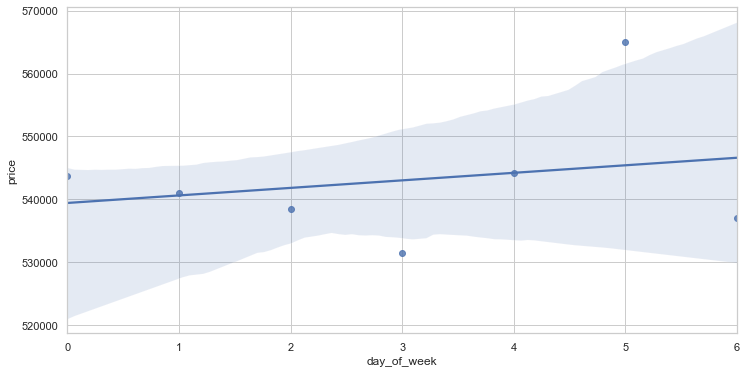

In [100]:
aux1 = df3[['day_of_week', 'price']].groupby( 'day_of_week' ).mean().reset_index()
sns.regplot(x='day_of_week', y='price', data=aux1);

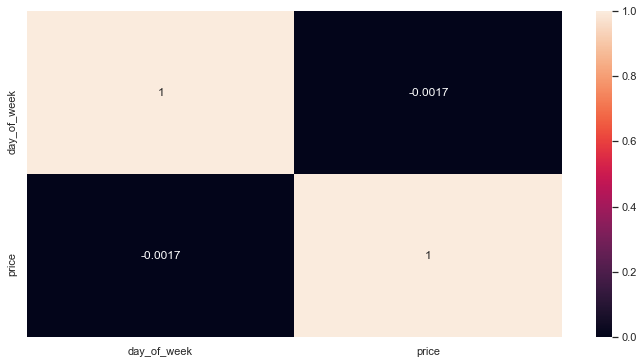

In [101]:
sns.heatmap(data=df3[['day_of_week', 'price']].corr(method='pearson'), annot=True);

#### Day of Month

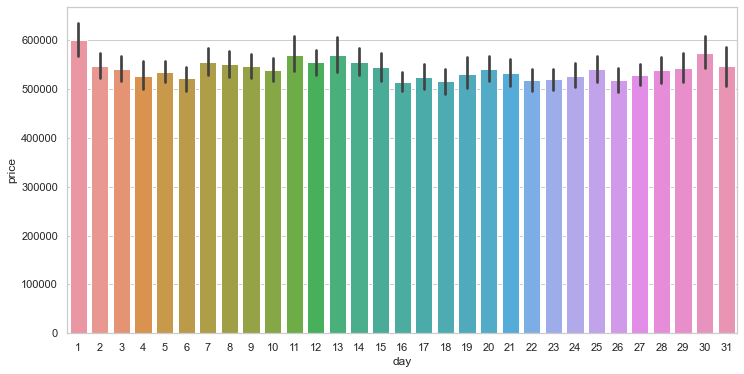

In [102]:
sns.barplot(x='day', y='price', data=df3);

C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


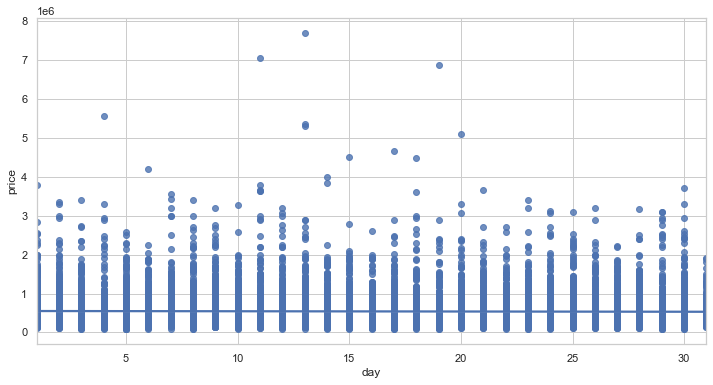

In [103]:
sns.regplot('day', 'price', data=df3);

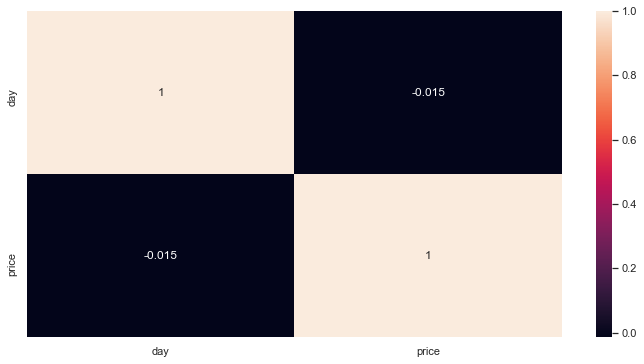

In [104]:
sns.heatmap(data=df3[['day', 'price']].corr(method='pearson'), annot=True);

#### Week of Year

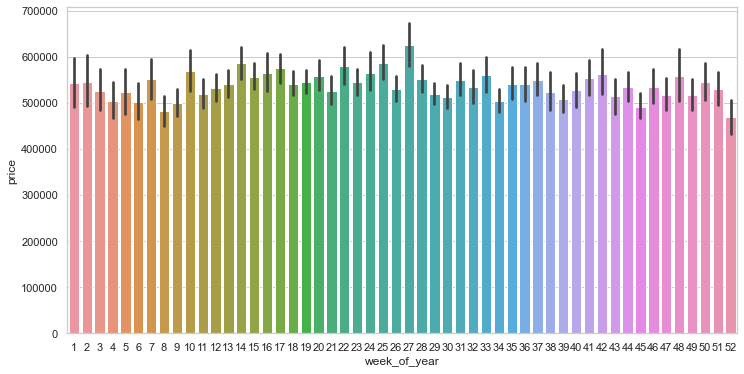

In [105]:
sns.barplot( x='week_of_year', y='price', data=df3 );

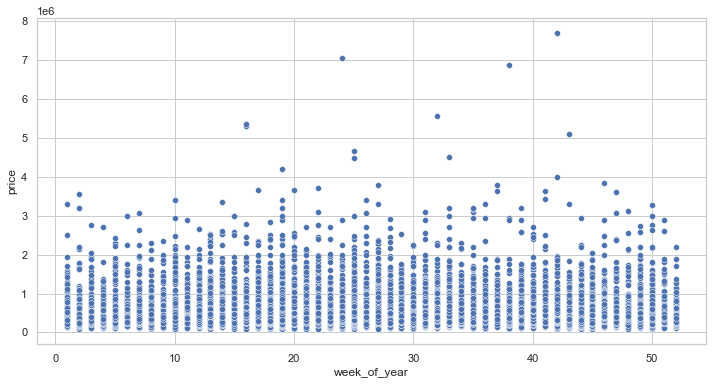

In [106]:
sns.scatterplot( x='week_of_year', y='price', data=df3 );

C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


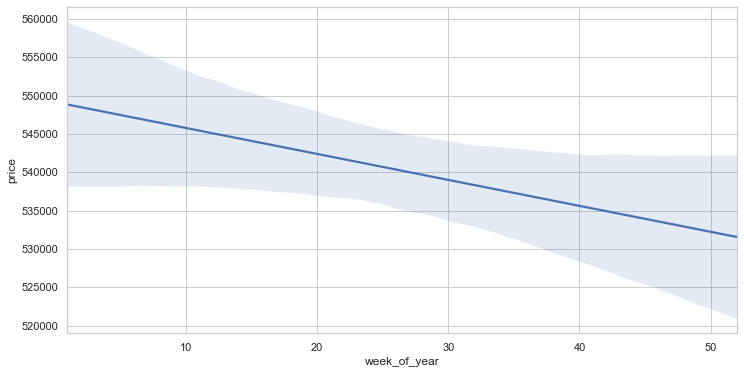

In [107]:
sns.regplot('week_of_year', 'price', data=df3, scatter=False);

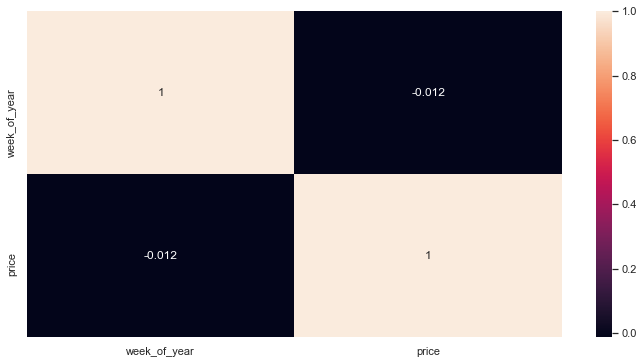

In [108]:
sns.heatmap(data=df3[['week_of_year', 'price']].corr(method='pearson'), annot=True);

#### Month

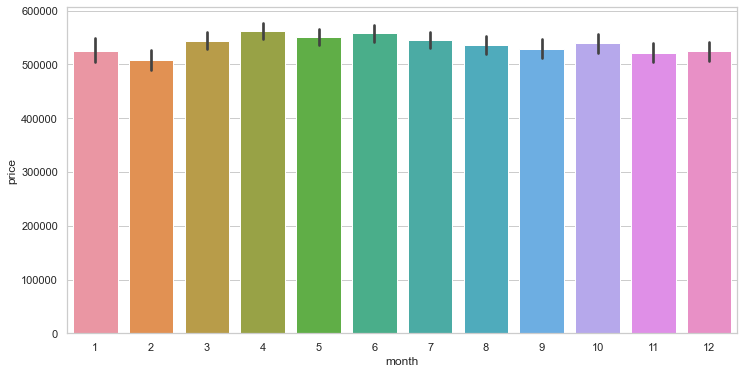

In [109]:
sns.barplot( x='month', y='price', data=df3 );

C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


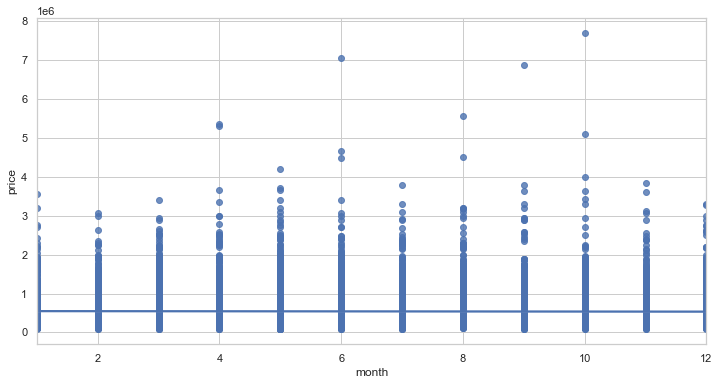

In [110]:
sns.regplot('month', 'price', data=df3);

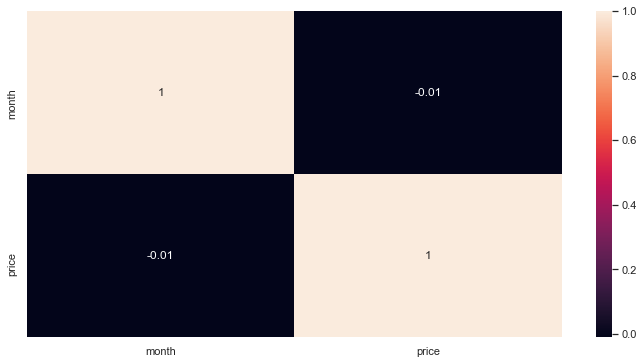

In [111]:
sns.heatmap(data=df3[['month', 'price']].corr(method='pearson'), annot=True);

#### Year

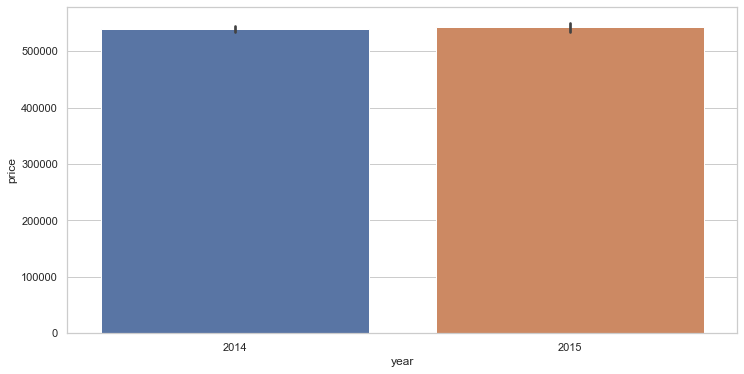

In [112]:
sns.barplot( x='year', y='price', data=df3 );

C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


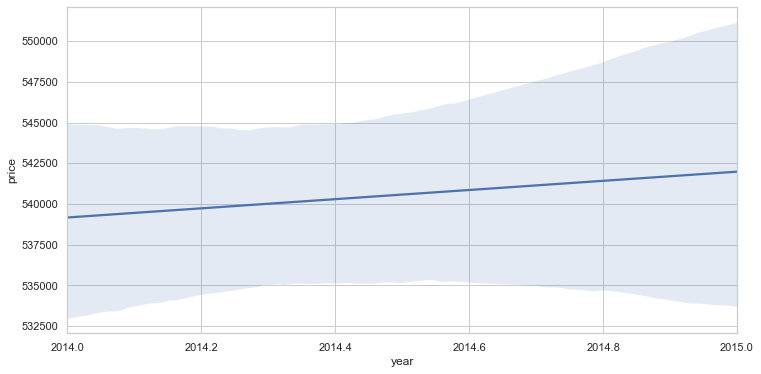

In [113]:
sns.regplot('year', 'price', data=df3, scatter=False);

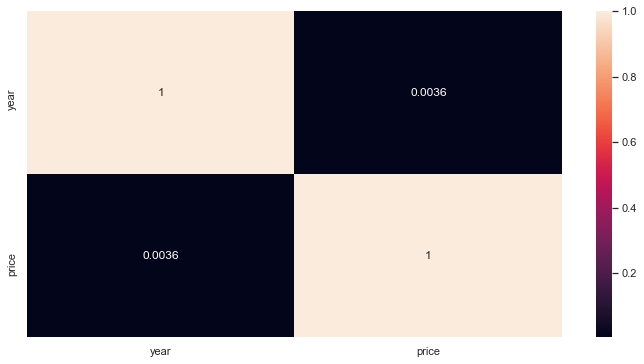

In [114]:
sns.heatmap(data=df3[['year', 'price']].corr(method='pearson'), annot=True);

Season

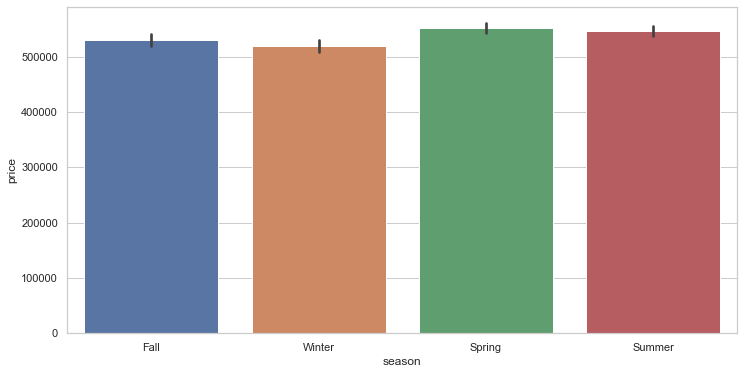

In [115]:
sns.barplot( x='season', y='price', data=df3 );

### 4.2.14 **Hypothesis 14** -  The Houses sold during the weekend are MORE EXPENSIVE
- ***True***

C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


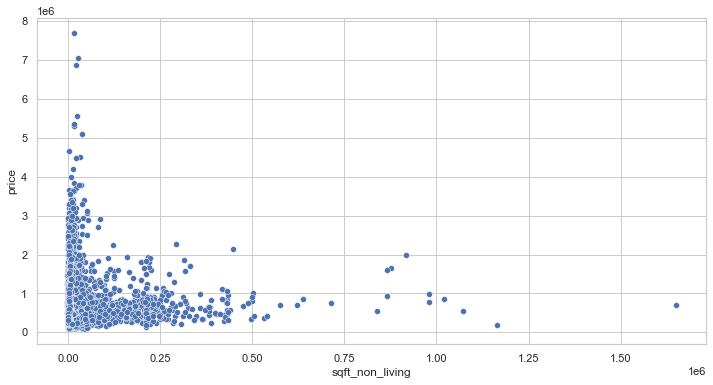

In [116]:
sns.scatterplot('sqft_non_living', 'price', data=df3);

C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


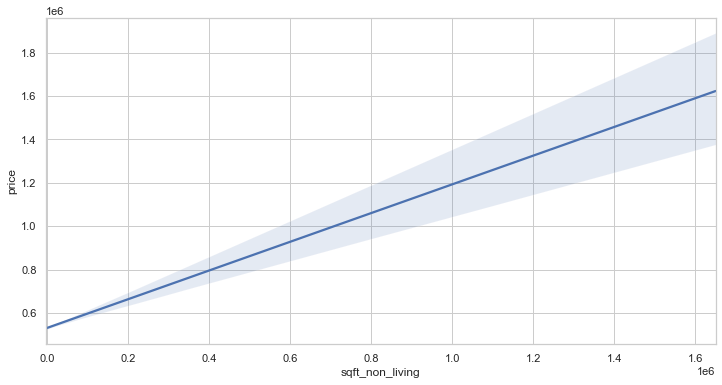

In [117]:
sns.regplot('sqft_non_living', 'price', data=df3, scatter=False);

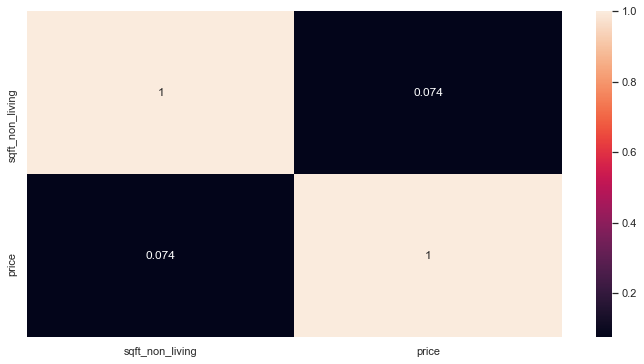

In [118]:
sns.heatmap(data=df3[['sqft_non_living', 'price']].corr(method='pearson'), annot=True);

### 4.2.1 Resumo das Hipóteses 
- Expectativas Inicais a Respeito das Variáveis
- A Hipótese foi Valida ou Rejeitada? 
- Ela pode gerar um Insight ou não? 
- Ela pode ser Relevante para o Modelo?

In [119]:
tab =[['Hypothesis', 'Conclusion', 'Relevant?', 'Correlation'],
      ['H1', 'True', 'Yes', 'High'],  
      ['H2', 'True', 'Yes', 'Medium'],  
      ['H3', 'True', 'Yes', 'High'],
      ['H4', 'True', 'Yes', 'Medium'],
      ['H5', 'True', 'Yes', 'High'],
      ['H6', 'True', 'Yes', 'Low'],
      ['H7', 'False', 'No', 'Low'],
      ['H8', 'Kind of True', 'Yes', 'Does Not Apply'],
      ['H9', 'True', 'Yes', 'Low'],      
      ['H10', 'True', 'Yes', 'High'],
      ['H11', 'True', 'Yes', 'Does Not Apply'],
      ['H12', 'False', 'Yes', 'Does Not Apply'],
      ['H13', 'False', 'No', 'Low'],
      ['H14', 'True', 'Yes', 'Low']
     ]  
print( tabulate( tab, headers='firstrow' ) )

Hypothesis    Conclusion    Relevant?    Correlation
------------  ------------  -----------  --------------
H1            True          Yes          High
H2            True          Yes          Medium
H3            True          Yes          High
H4            True          Yes          Medium
H5            True          Yes          High
H6            True          Yes          Low
H7            False         No           Low
H8            Kind of True  Yes          Does Not Apply
H9            True          Yes          Low
H10           True          Yes          High
H11           True          Yes          Does Not Apply
H12           False         Yes          Does Not Apply
H13           False         No           Low
H14           True          Yes          Low


## 4.3 Análise Multivariada

### 4.3.1 Numerical Attributes

In [120]:
# # df3.corr()  --> too many columns, awful to read
# plt.figure(figsize=(24,24))
# sns.heatmap(df3.corr(method='pearson'), annot=Tru=e);

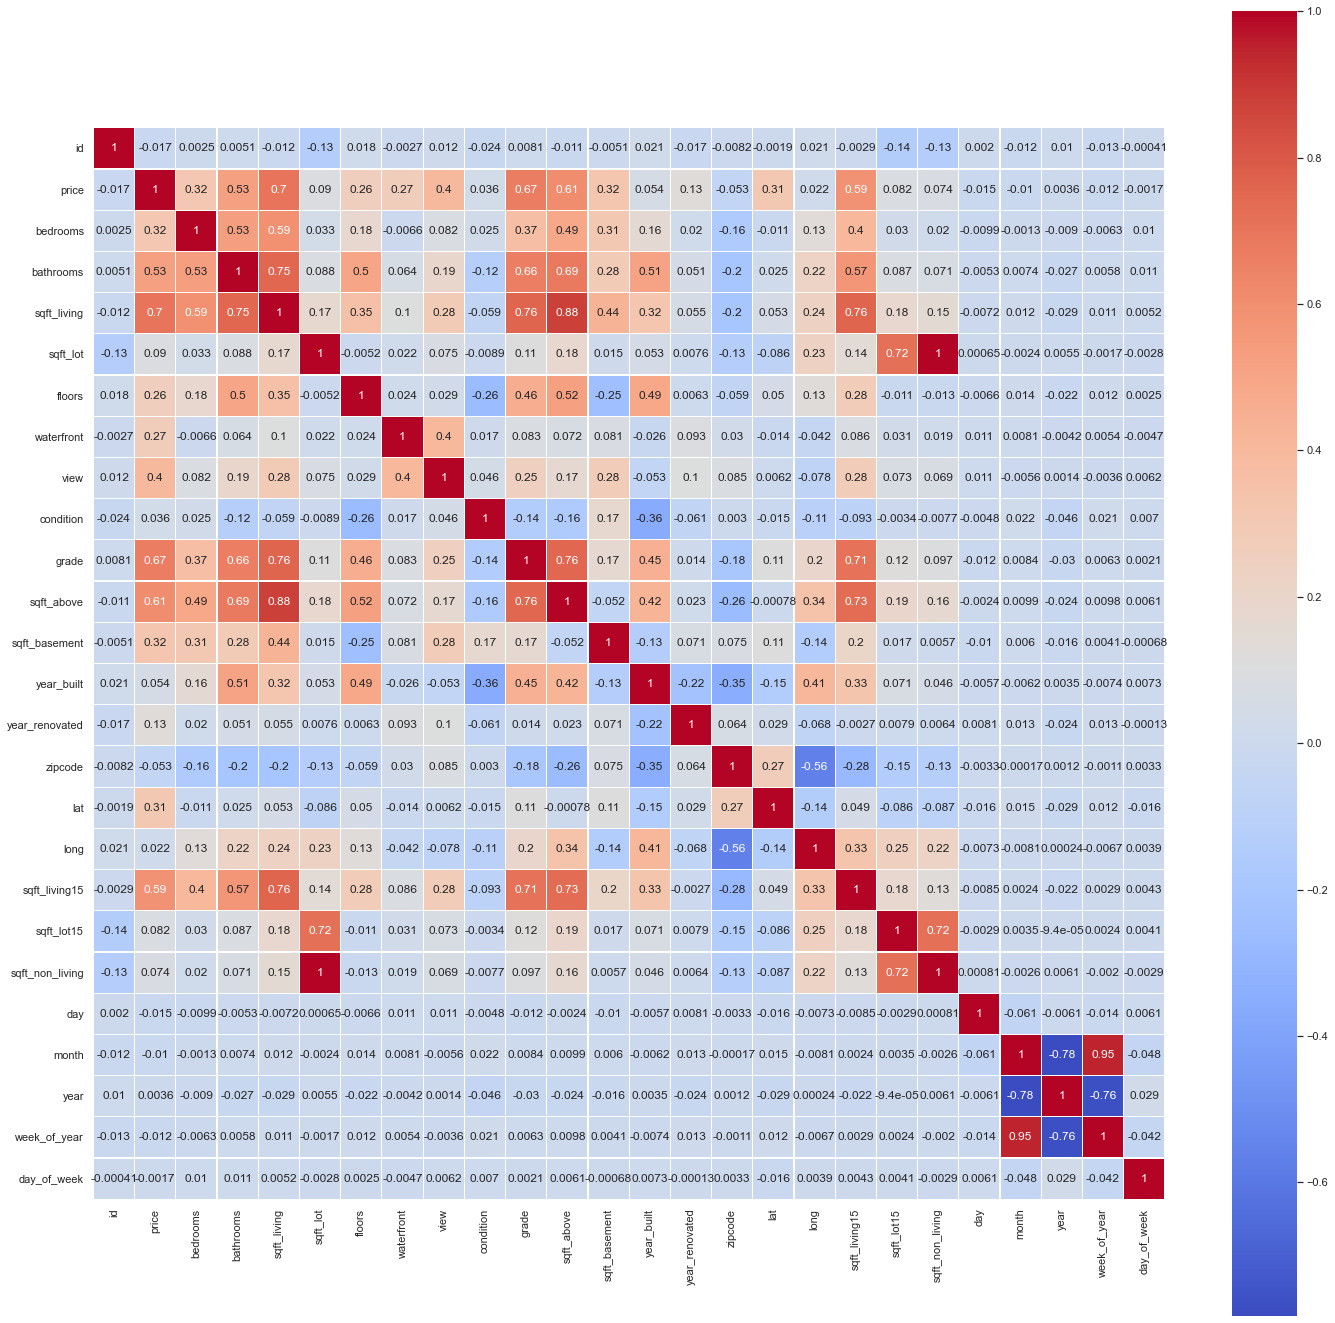

In [121]:
plt.figure(figsize=(24,24)) 
sns.heatmap(data=df3.corr(),annot=True,linewidths=0.2,cmap='coolwarm', square=True);

# 5.0 Data Preparation

In [122]:
df5 = df3.copy()

### 5.1 - Plot of Features, Searching for Outliers to choose MinMaxScaler or RobustScaler

C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


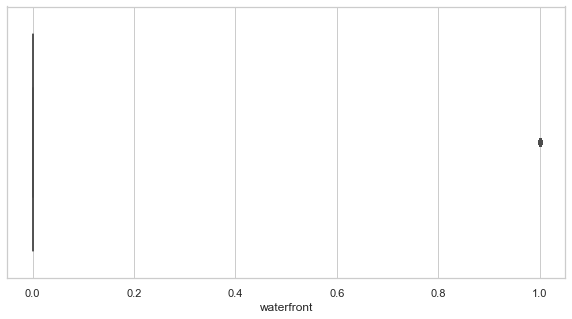

In [123]:
plt.rcParams['figure.figsize'] = [10, 5]
sns.boxplot('waterfront', data=df5);

C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


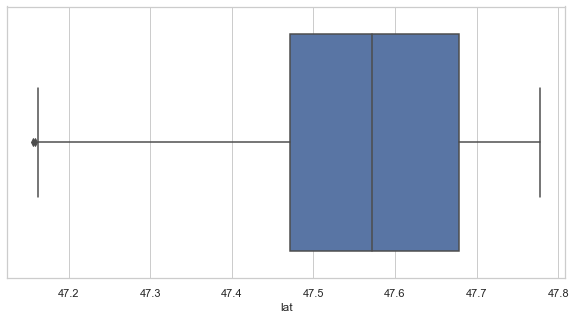

In [124]:
sns.boxplot('lat', data=df5);

C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


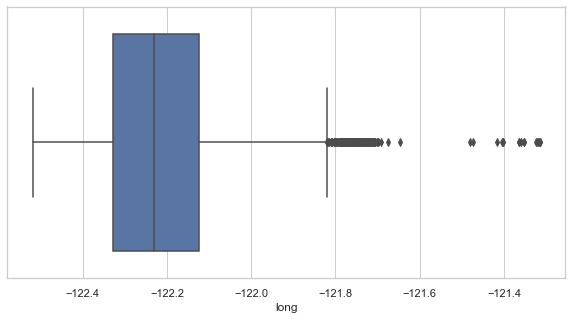

In [125]:
sns.boxplot('long', data=df5);

C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


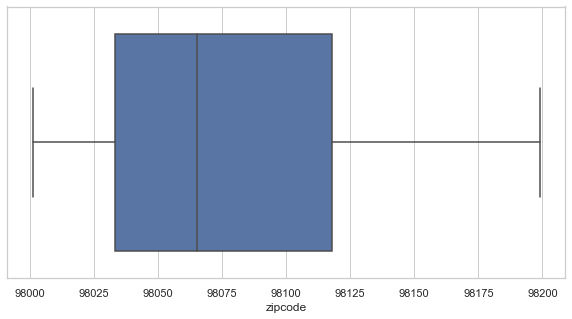

In [126]:
sns.boxplot('zipcode', data=df5);

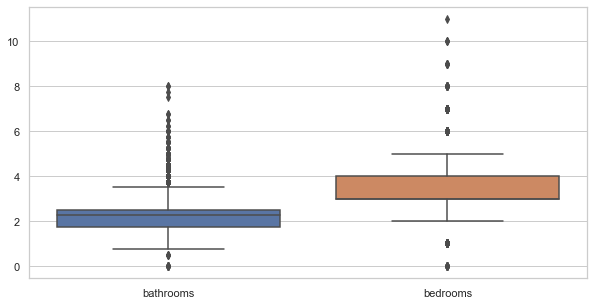

In [127]:
sns.boxplot(data=df5[['bathrooms', 'bedrooms']]);

C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWar

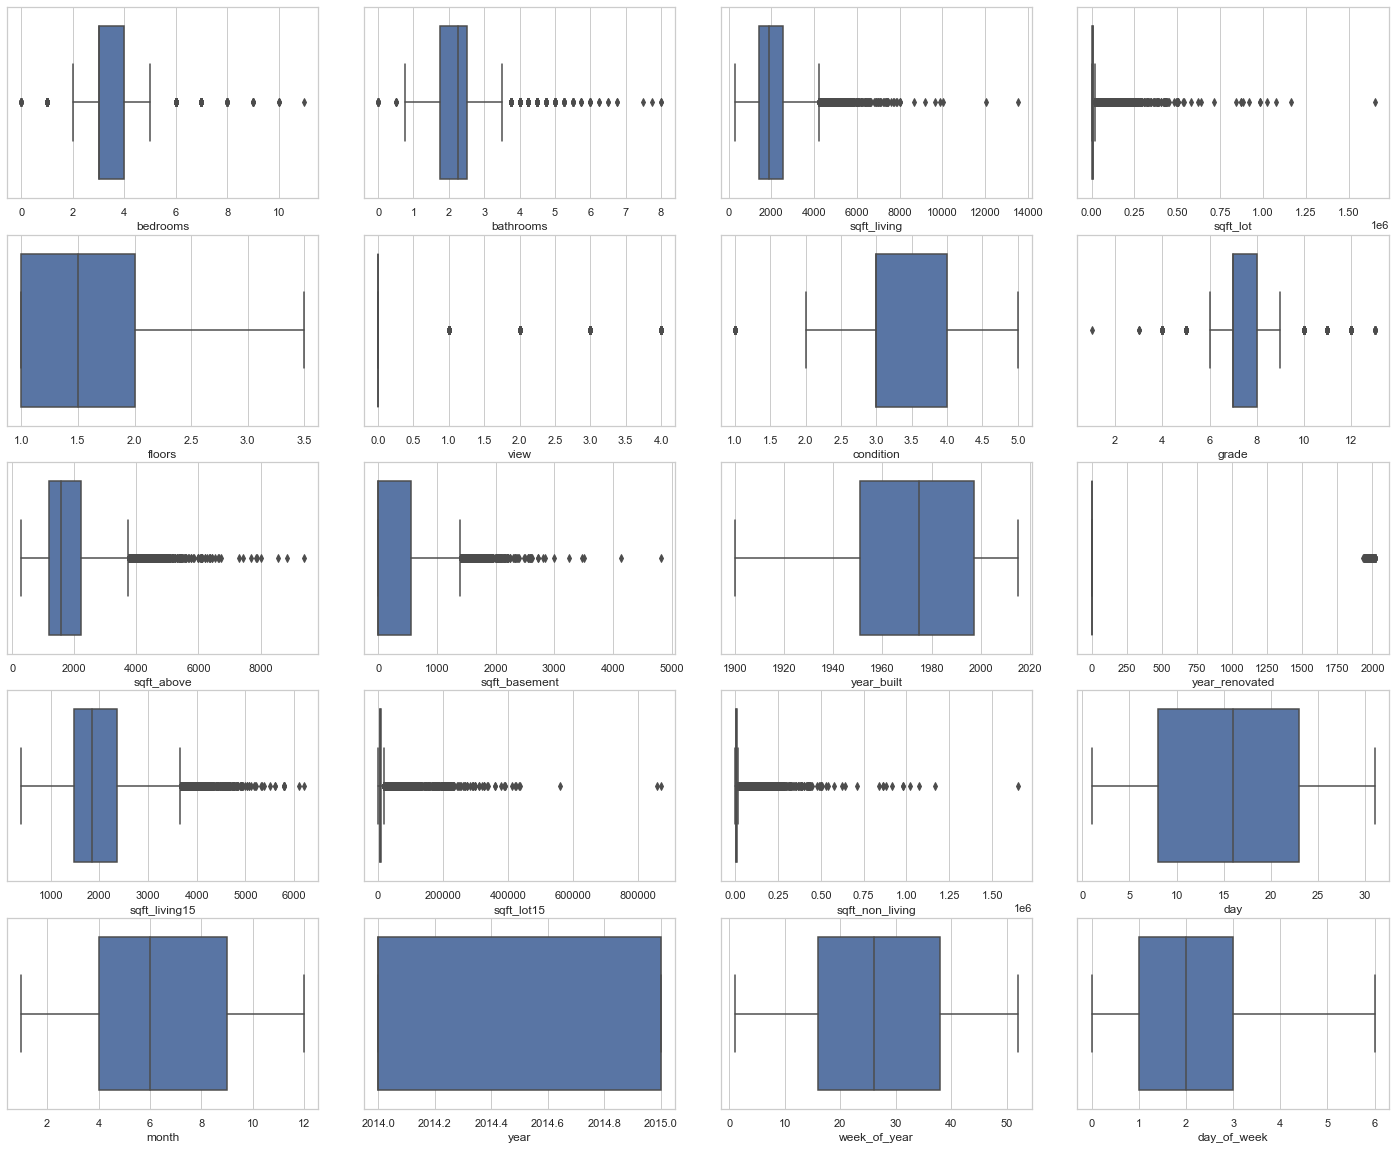

In [128]:
plt.rcParams['figure.figsize'] = [20, 16]
fig, axes = plt.subplots(5,4)
plt.tight_layout()

features = df5.drop(['id', 'date', 'price', 'zipcode', 'lat', 'long', 'season', 'waterfront'], axis=1).columns

for i in range(1, len(features) + 1):
    plt.subplot(5, 4, i)
    sns.boxplot(df5[features[i - 1]])

## 5.2 Standardization

## 5.3 Rescaling

In [129]:
rs = RobustScaler()
mms = MinMaxScaler()

In [130]:
df5['bedrooms'] = rs.fit_transform(df5[['bedrooms']].values)

df5['bathrooms'] = rs.fit_transform(df5[['bathrooms']].values)

df5['sqft_living'] = rs.fit_transform(df5[['sqft_living']].values)

df5['sqft_lot'] = rs.fit_transform(df5[['sqft_lot']].values)

df5['grade'] = rs.fit_transform(df5[['grade']].values)

df5['sqft_above'] = rs.fit_transform(df5[['sqft_above']].values)

df5['sqft_basement'] = rs.fit_transform(df5[['sqft_basement']].values)

df5['long'] = rs.fit_transform(df5[['long']].values)

df5['sqft_living15'] = rs.fit_transform(df5[['sqft_living15']].values)

df5['sqft_lot15'] = rs.fit_transform(df5[['sqft_lot15']].values)

df5['sqft_non_living'] = rs.fit_transform(df5[['sqft_non_living']].values)

df5['floors'] = mms.fit_transform(df5[['floors']].values)

df5['view'] = mms.fit_transform(df5[['view']].values)

df5['condition'] = mms.fit_transform(df5[['condition']].values)

df5['year_built'] = mms.fit_transform(df5[['year_built']].values)

df5['year_renovated'] = mms.fit_transform(df5[['year_renovated']].values)

df5['zipcode'] = mms.fit_transform(df5[['zipcode']].values) # --> faz sentido usar zipcode? e usar scaler em zipcode?

df5['lat'] = mms.fit_transform(df5[['lat']].values)

df5['year'] = mms.fit_transform(df5[['year']].values)

df5.sample(3)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,year_built,year_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_non_living,day,month,year,week_of_year,day_of_week,season
6252,1150900080,2015-04-27,846450.0,1.0,0.333333,1.602136,-0.022662,0.4,0,0.0,0.5,2.0,2.107843,0.000000,0.895652,0.0,0.141414,0.649349,1.054187,1.379310,-0.025887,-0.346428,27,4,1.0,18,0,Spring
8767,7812800515,2014-10-25,159075.0,1.0,-1.000000,-0.293725,-0.251228,0.0,0,0.0,0.5,-1.0,-0.754902,1.410714,0.382609,0.0,0.893939,0.548818,-0.049261,-0.597701,-0.224954,-0.195753,25,10,0.0,43,5,Fall
2050,8732040810,2014-11-04,235000.0,1.0,0.666667,-0.124611,0.454123,0.0,0,0.0,0.5,1.0,-0.303922,0.928571,0.686957,0.0,0.111111,0.243687,-0.763547,0.264368,0.140471,0.485610,4,11,0.0,45,1,Fall


## 5.4 Feature Transformation

### 5.4.1 Encoding

In [131]:
only_cat = df5.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
only_cat.columns

Index(['season'], dtype='object')

In [132]:
df5 = pd.get_dummies(df5, prefix=['season'], columns=['season'])

In [133]:
df5.sample()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,year_built,year_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_non_living,day,month,year,week_of_year,day_of_week,season_Fall,season_Spring,season_Summer,season_Winter
12091,1233100260,2014-11-14,490000.0,0.0,-1.666667,-0.578549,0.357456,0.4,0,0.0,0.75,0.0,-0.294118,0.0,0.173913,0.0,0.161616,0.838668,0.256158,-0.091954,0.040536,0.479145,14,11,0.0,46,4,1,0,0,0


### 5.4.2 Response Variable Transformation

In [134]:
df5['price'] = np.log1p(df5['price'])

### 5.4.3 Nature Transformation

In [135]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# day of month
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

In [136]:
df5.tail(2)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,year_built,year_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_non_living,day,month,year,week_of_year,day_of_week,season_Fall,season_Spring,season_Summer,season_Winter,day_of_week_sin,day_of_week_cos,day_sin,day_cos,month_sin,month_cos,week_of_year_sin,week_of_year_cos
21611,291310100,2015-01-16,12.899222,0.0,0.333333,-0.275923,-0.926128,0.4,0,0.0,0.5,1.0,0.039216,0.0,0.904348,0.0,0.131313,0.608975,0.793103,-0.494253,-1.270857,-0.88394,16,1,1.0,3,4,0,0,0,1,-0.433884,-0.900969,-2.079117e-01,-0.978148,0.500000,0.866025,0.354605,0.935016
21612,1523300157,2014-10-15,12.691584,-1.0,-2.000000,-0.792167,-1.158412,0.4,0,0.0,0.5,0.0,-0.529412,0.0,0.939130,0.0,0.722222,0.704842,-0.339901,-0.942529,-1.256810,-1.01540,15,10,0.0,42,2,1,0,0,0,0.974928,-0.222521,1.224647e-16,-1.000000,-0.866025,0.500000,-0.935016,0.354605


# 6.0 Feature Selection

In [137]:
df6 = df5.copy()

## 6.1 Split Dataframe into Training and Test Dataset

In [138]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'id', 'date']
df6 = df6.drop(cols_drop, axis=1)

In [139]:
X_train, X_test, y_train, y_test =  train_test_split(df6.drop('price', axis=1), df6['price'], random_state = 16, train_size=0.8)

print('\nTamanho treino: {}'.format(X_train.shape[0]))
print('Tamanho teste: {}'.format(X_test.shape[0]))


Tamanho treino: 17289
Tamanho teste: 4323


## 6.2 Boruta as Feature Selector

In [140]:
# training and test dataset for Boruta
X_train_n = X_train.values
y_train_n = y_train.values.ravel()

In [141]:
# define RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-2)

# define Boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	13
Tentative: 	0
Rejected: 	19


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	13
Tentative: 	0
Rejected: 	19


### 6.2.1 Best Features from Boruta

In [142]:
cols_selected = boruta.support_.tolist()

# best features
X_train_fs = X_train
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [143]:
cols_selected_boruta

['sqft_living',
 'sqft_lot',
 'waterfront',
 'view',
 'grade',
 'sqft_above',
 'year_built',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'sqft_non_living']

In [144]:
cols_not_selected_boruta

['bathrooms',
 'bedrooms',
 'condition',
 'day_cos',
 'day_of_week_cos',
 'day_of_week_sin',
 'day_sin',
 'floors',
 'month_cos',
 'month_sin',
 'season_Fall',
 'season_Spring',
 'season_Summer',
 'season_Winter',
 'sqft_basement',
 'week_of_year_cos',
 'week_of_year_sin',
 'year',
 'year_renovated']

## 6.3 Manual Feature Selection

In [145]:
cols_selected_boruta = [
 'sqft_living',
 'sqft_lot',
 'waterfront',
 'view',
 'grade',
 'sqft_above',
 'year_built',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'sqft_non_living']

# columns to add
feat_to_add = ['date', 'price']
# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

## 6.4 Importance Selection

### 6.4.1 Feature Selection Using Random Forest Classifier

### 6.4.2 Feature Selection Using Extra-Trees Classifier

In [146]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-5, random_state=42).fit(X_train, y_train)
#rf.score(X_test_n, y_test_n)

In [147]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
grade,0.344273
lat,0.288292
sqft_living,0.175613
long,0.043295
sqft_living15,0.023718
year_built,0.017672
sqft_above,0.012827
sqft_lot15,0.011737
zipcode,0.009714
view,0.008700


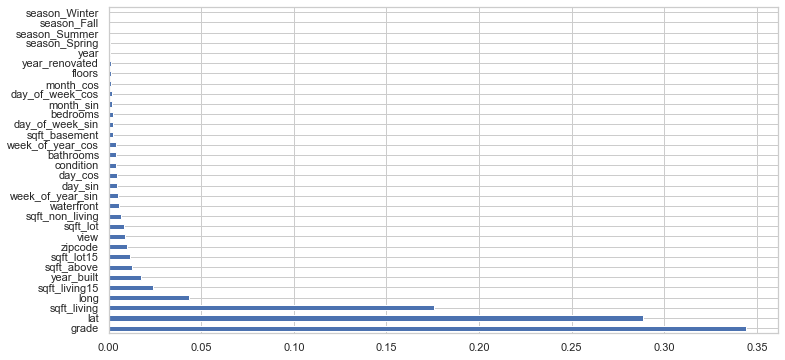

In [148]:
plt.rcParams['figure.figsize'] = [12, 6]
pd.Series(rf.feature_importances_, index=X_train.columns).nlargest(len(X_train.columns)).plot(kind='barh');

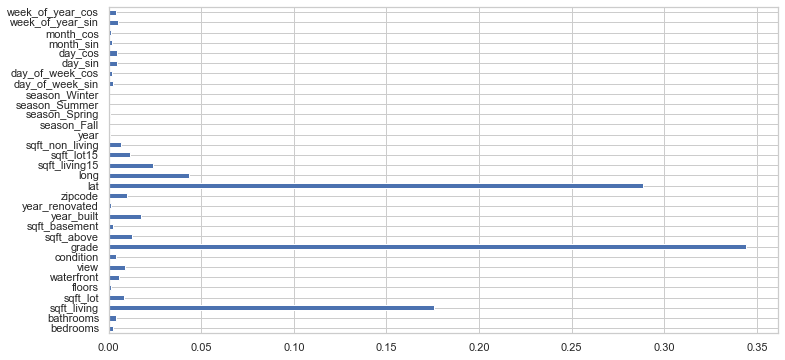

In [149]:
pd.Series(rf.feature_importances_, index=X_train.columns).plot(kind='barh');

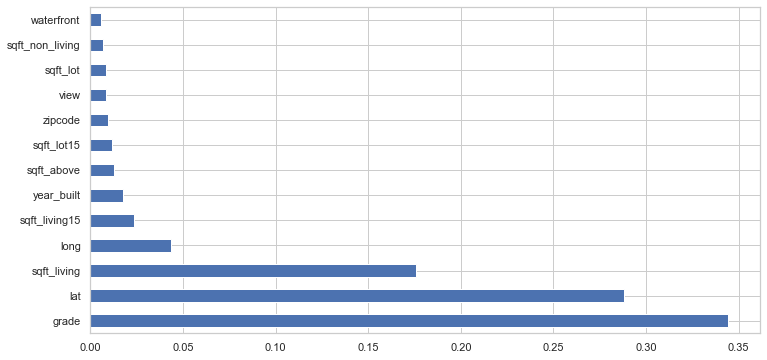

In [150]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns);
feat_importances.nlargest(13).plot(kind='barh');

### 6.4.2 Feature Selection Using Extra-Trees Classifier

In [151]:
et = ExtraTreesRegressor(n_jobs=-5)
et.fit(X_train, y_train)

feature_importances = pd.DataFrame(et.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
lat,0.279028
grade,0.200654
sqft_living,0.145277
sqft_living15,0.077265
sqft_above,0.059987
bathrooms,0.034911
long,0.025120
view,0.024682
year_built,0.022792
zipcode,0.017306


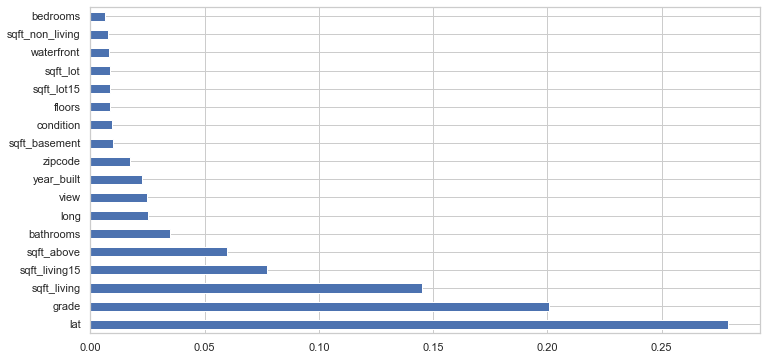

In [152]:
feat_importances = pd.Series(et.feature_importances_, index=X_train.columns);
feat_importances.nlargest(18).plot(kind='barh');

## 6.5 Selecting Columns Based on Everything (Hypothesis, Boruta and Feature Importances)

In [153]:
final_cols = [
'lat',
'grade',
'sqft_living',
'sqft_living15',
'sqft_above',
'long',          
'view',
'year_built',        # hypothesis made me think the year built woudln't matter much, but maybe it's because the range of values eluded me
'zipcode',               
'condition',                      
'waterfront',
'sqft_lot15',     
'sqft_lot',        
'sqft_non_living', 
'bedrooms'
]

# columns to add
feat_to_add = ['date', 'price']
# final features
final_cols_full = cols_selected_boruta.copy()
final_cols_full.extend(feat_to_add)

# 7.0 Machine Learning Modelling

In [154]:
x_train = X_train[final_cols]
x_test = X_test[final_cols]

In [155]:
from sklearn.metrics import make_scorer
mape_scorer = make_scorer(log_mean_absolute_percentage_error)

## 7.1 Average Model

In [156]:
aux1 = x_test.copy()
aux1['price'] = y_test.copy()

# prediction
aux1['predictions'] = aux1['price'].mean()
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))  # exp pois as sales tinham sido transformados pra log
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,224575.262238,0.44431,371912.689563


## 7.2 Linear Regression Model

In [157]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,117302.227112,0.210618,257470.598709


### 7.2.1. Linear Regression Model - Cross Validation

In [158]:
lr_result_cv = cross_val_score(estimator=lr, X=x_test, y=y_test, cv=10, scoring=mape_scorer, n_jobs=-6)
print(lr_result_cv.mean(), lr_result_cv.std())

0.21166338613748575 0.008264575060555078


## 7.3 Linear Regression Regularized Model - Lasso

In [159]:
# model
lrr = Lasso( alpha=0.001 ).fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,117459.131162,0.210787,256152.251243


### 7.3.1. Lasso - Cross Validation

In [160]:
lrr_result_cv = cross_val_score(estimator=lrr, X=x_test, y=y_test, cv=10, scoring=mape_scorer, n_jobs=-6)
print(lrr_result_cv.mean(), lrr_result_cv.std())

0.21167080468293395 0.008467995784931834


## 7.4 Random Forest Model

In [161]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-5, random_state=42).fit(x_train, y_train)

# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,70332.955407,0.127934,127792.403184


### 7.4.1. Random Forest Regressor - Cross Validation

In [162]:
rf_result_cv = cross_val_score(estimator=rf, X=x_test, y=y_test, cv=10, scoring=mape_scorer, n_jobs=-6)
print(rf_result_cv.mean(), rf_result_cv.std())

0.13890435116837746 0.004825428931104397


## 7.5 XGBoost Regressor

In [163]:
# model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                              n_estimators=200,
                              n_jobs=-5,
                              eta=0.01, 
                              max_depth=10, 
                              subsample=0.7,
                              colsample_bytee=0.9).fit(x_train, y_train)

# prediction
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

[21:01:52] WARNING: D:\Build\xgboost\xgboost-1.1.0.git\python-package\build\temp.win-amd64-3.7\Release\xgboost\src\learner.cc:480: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,451116.613267,0.809318,559422.811817


### 7.5.1. XGBoost Regressor - Cross Validation

In [164]:
xgb_result_cv = cross_val_score(estimator=model_xgb, X=x_test, y=y_test, cv=10, scoring=mape_scorer, n_jobs=-6)
print(xgb_result_cv.mean(), xgb_result_cv.std())

0.8081468245228833 0.004046432258188963


## 7.6. Compare Model's Performance

### 7.6.1. Single Performance

In [165]:
modeling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
#modeling_result.to_pickle('modeling_result.pkl')
modeling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,70332.955407,0.127934,127792.403184
0,Linear Regression - Lasso,117459.131162,0.210787,256152.251243
0,Linear Regression,117302.227112,0.210618,257470.598709
0,Average Model,224575.262238,0.444310,371912.689563
0,XGBoost Regressor,451116.613267,0.809318,559422.811817


### 7.6.2. Real Performance - Cross Validation

In [166]:
list_ = [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv]

for i in range(0, 4):
    print('{} - MAPE: {} +- {}'.format(modeling_result.iloc[i+1, 0], list_[i].mean(), list_[i].std()))

Linear Regression - MAPE: 0.21166338613748575 +- 0.008264575060555078
Linear Regression - Lasso - MAPE: 0.21167080468293395 +- 0.008467995784931834
Random Forest Regressor - MAPE: 0.13890435116837746 +- 0.004825428931104397
XGBoost Regressor - MAPE: 0.8081468245228833 +- 0.004046432258188963


# 8.0 Hyperparameter Fine Tuning

In [167]:
param = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400]}

## 8.1 Random Search

In [168]:
# random_search = RandomizedSearchCV(
#     estimator=rf,
#     param_distributions=param,
#     n_iter=100,
#     n_jobs=-5,
#     cv=5,
#     random_state=0
# )

# search = random_search.fit(x_train, y_train)
# search.best_params_

## 8.2 Bayesian Search

In [169]:
# bayes_search = BayesSearchCV(
#     estimator=model_xgb,
#     search_spaces=param,
#     n_jobs=-5,
#     n_iter=30,
#     random_state=0,
#     cv=5
#  )
# bayes_search.fit(X_train, y_train)
# bayes_search.score(X_test, y_test)

## 8.3 Final Model

In [170]:
param_tuned = {
 'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': False}

In [171]:
rf_tuned = RandomForestRegressor(n_estimators=400, n_jobs=-5, random_state=42, min_samples_split=2, min_samples_leaf=1,
                                      max_features='sqrt', max_depth=30, bootstrap=False).fit(x_train, y_train)

# prediction
yhat_rf_tuned = rf_tuned.predict(x_test)

# performance
rf_result_tuned = ml_error('Random Forest', np.expm1(y_test), np.expm1(yhat_rf_tuned))
rf_result_tuned

,Model Name,MAE,MAPE,RMSE
0,Random Forest,68795.097563,0.126276,125110.293571


In [172]:
mpe = mean_percentage_error(y_test , yhat_rf_tuned)
mpe  # mpe < 0   -->  o modelo está superestimando os preços (mas bem pouco)

-1.3214278833185612e-05

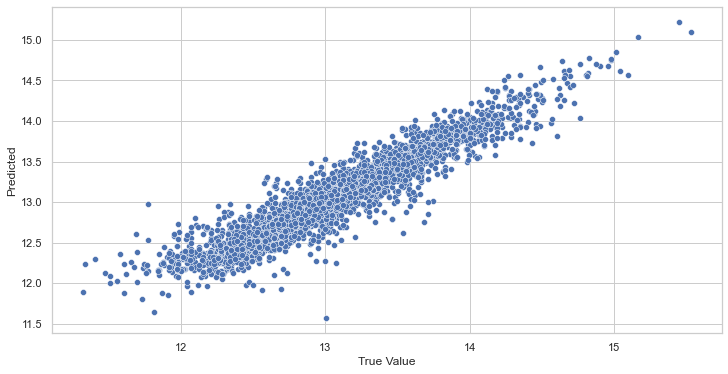

In [173]:
# real x predito
sns.scatterplot(x= y_test, y= yhat_rf_tuned );
plt.xlabel('True Value');
plt.ylabel('Predicted');

In [174]:
# 	Model Name	         MAE	        MAPE	     RMSE
# 	Random Forest	68795.097563	0.126276	125110.293571

In [175]:
#save trained model
pickle.dump(rf_tuned, open(r'D:\MEGA\Programming\Data Science\_My Projects\Store Item Demand Forecasting Challenge\model_rockethouse_rf_tuned_business.pkl', 'wb'))

# 9.0 Error Translation and Interpretation

In [180]:
df9 = X_test.copy()

df9.loc[:, 'price'] =  np.expm1(y_test)
df9.loc[:, 'predictions'] = np.expm1(yhat_rf_tuned)

In [ ]:
df9.to_csv('D:\df9_business.csv')

In [183]:
df9.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,year_built,year_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_non_living,year,season_Fall,season_Spring,season_Summer,season_Winter,day_of_week_sin,day_of_week_cos,day_sin,day_cos,month_sin,month_cos,week_of_year_sin,week_of_year_cos,price,predictions
10368,0.0,-0.333333,-0.445038,-0.213517,0.0,0,0.0,0.75,0.0,-0.637255,0.892857,0.408696,0.000000,0.575758,0.847193,-0.334975,-0.586207,-0.315055,-0.126970,0.0,0,0,1,0,0.781831,0.623490,2.079117e-01,0.978148,-0.500000,-8.660254e-01,-0.120537,-9.927089e-01,590000.0,501309.272091
1691,0.0,-0.333333,-0.311526,-0.047271,0.0,0,0.0,0.50,-1.0,0.000000,0.000000,0.800000,0.000000,0.000000,0.200257,-0.103448,-0.827586,0.066222,0.014726,0.0,0,1,0,0,-0.433884,-0.900969,-2.449294e-16,1.000000,0.500000,-8.660254e-01,0.464723,-8.854560e-01,196440.0,218666.121950
18739,1.0,0.000000,0.195817,0.155800,0.0,0,0.0,0.75,0.0,0.039216,0.946429,0.652174,0.000000,0.146465,0.337462,0.098522,0.057471,0.752120,0.118350,0.0,1,0,0,0,0.433884,-0.900969,-8.660254e-01,0.500000,-1.000000,-1.836970e-16,-1.000000,-1.836970e-16,325000.0,282713.760141
10947,0.0,0.333333,-0.195817,-0.794936,0.4,0,0.0,0.50,0.0,0.127451,0.000000,0.886957,0.000000,0.262626,0.855075,0.921182,-0.172414,-0.901219,-0.767027,0.0,1,0,0,0,-0.433884,-0.900969,-4.067366e-01,-0.913545,-0.866025,5.000000e-01,-0.935016,3.546049e-01,442500.0,458896.562808
14836,0.0,-0.333333,-0.471740,0.244501,0.4,0,0.0,0.25,0.0,-0.176471,0.000000,0.400000,0.983623,0.000000,0.169535,-0.088670,-0.436782,0.423820,0.343016,0.0,1,0,0,0,0.433884,-0.900969,9.510565e-01,0.309017,-0.500000,8.660254e-01,-0.748511,6.631227e-01,215500.0,216948.269352


In [184]:
len(df9.predictions)

4323

## 9.1 Business Performacne

In [185]:
model_summary = rf_result_tuned.drop('Model Name', axis=1)

In [186]:
# What's the Mean and Sum of all Houses Sold in this Model?
model_summary['Sum_of_Predictions'] = df9['predictions'].sum()
model_summary['Mean_of_Predictions'] = df9['predictions'].mean()
# sum predictions is the sum of the houses' price sold during the next 4 weeks

# Scenarios

model_summary['Lowest_Daily_Price'] = model_summary['Mean_of_Predictions'] - model_summary['MAE']
model_summary['Highest_Daily_Price'] = model_summary['Mean_of_Predictions'] + model_summary['MAE']
model_summary['4_Week_Low_Scenario'] = model_summary['Sum_of_Predictions'] - model_summary['Sum_of_Predictions'] * model_summary['MAPE']
model_summary['4_Week_High_Scenario'] = model_summary['Sum_of_Predictions'] + model_summary['Sum_of_Predictions'] * model_summary['MAPE']

model_summary

,MAE,MAPE,RMSE,Sum_of_Predictions,Mean_of_Predictions,Lowest_Daily_Price,Highest_Daily_Price,4_Week_Low_Scenario,4_Week_High_Scenario
0,68795.097563,0.126276,125110.293571,2.282450e+09,527978.267852,459183.170289,596773.365416,1.994232e+09,2.570668e+09


## 9.2 Total Performance

In [187]:
performance = model_summary[['Sum_of_Predictions', 'Mean_of_Predictions', 'Lowest_Daily_Price', 'Highest_Daily_Price', '4_Week_Low_Scenario', '4_Week_High_Scenario']].applymap('$ {:,.2f}'.format)
performance

,Sum_of_Predictions,Mean_of_Predictions,Lowest_Daily_Price,Highest_Daily_Price,4_Week_Low_Scenario,4_Week_High_Scenario
0,"$ 2,282,450,051.93","$ 527,978.27","$ 459,183.17","$ 596,773.37","$ 1,994,232,375.55","$ 2,570,667,728.30"


## 9.3 Machine Learning Performance

In [188]:
df9.loc[:, 'error'] = df9.loc[:, 'price'] - df9.loc[:, 'predictions']
df9.loc[:, 'error_rate'] = df9.loc[:, 'predictions'] / df9.loc[:, 'price']

C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


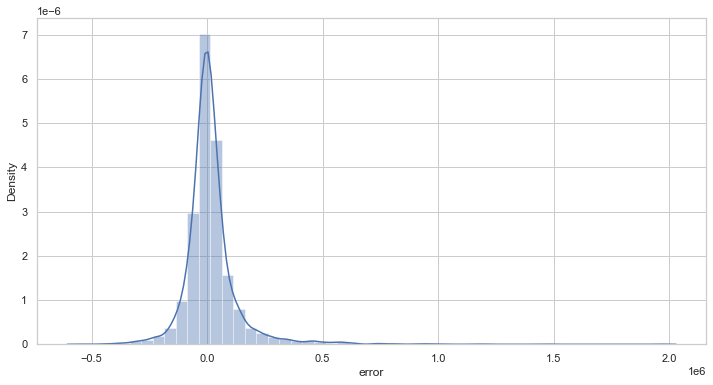

In [191]:
sns.distplot(df9['error']);

C:\Users\Kamel\miniconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


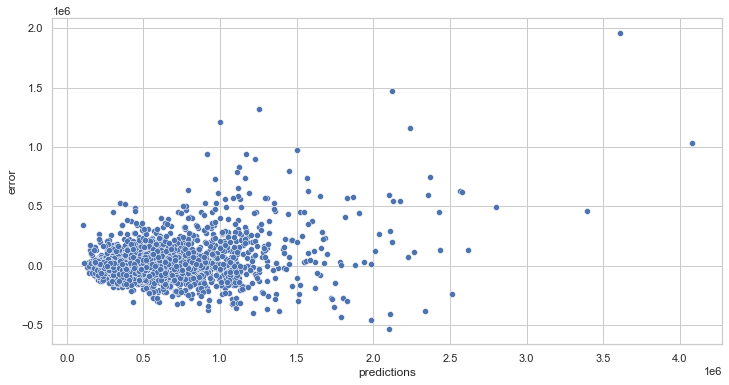

In [192]:
sns.scatterplot(df9['predictions'], df9['error']);

# 10 DEPLOY MODEL TO PRODUCTION

### Requirements.txt

## 10.1 Project Class

## 10.2 API Handler

## 10.3 API Tester

# 11 Business Questions Analysis

## Seu trabalho como Data Scientist é responder as seguinte perguntas:

#### Quais casas o CEO da House Rocket deveria comprar e por qual preço de compra?<br>Uma vez a casa em posse da empresa, qual o melhor momento para vendê-las e qual seria o preço da venda?<br>A House Rocket deveria fazer uma reforma para aumentar o preço da venda?<br><br>Quais seriam as sugestões de mudanças?<br>Qual o incremento no preço dado por cada opção de reforma?<br><br>Não acho que tenha dados referentes a cada tipo de mudança/reforma, pra dizer qual que deve ser feita

Eu comecei modelando como uma Time Series, pois tem data, e eu estava acostumado a lidar com problemas de previsão de vendas. Mas acho que este caso não é uma Time Series, cada evento é independente dos outros.

Pela Hipótese 8, talvez compense fazer reforma nas casas para vendê-las.


In [194]:
plt.rcParams['figure.figsize'] = [12, 6]

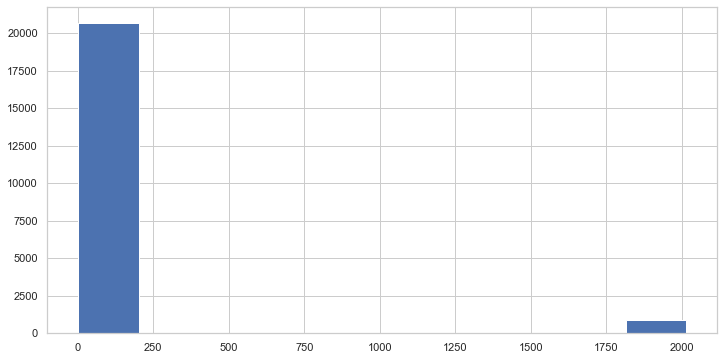

In [195]:
df3['year_renovated'].hist();

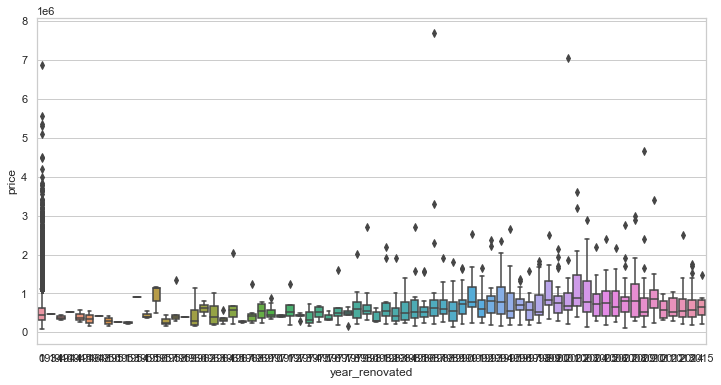

In [196]:
sns.boxplot(data=df3, x='year_renovated', y='price');

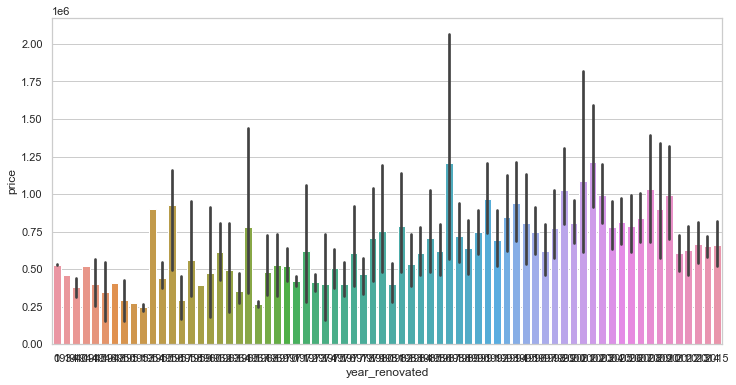

In [197]:
sns.barplot(data=df3, x='year_renovated', y='price');

In [198]:
print('Mean Price of Houses that were renovated: {}'.format(renovated['price'].mean()))
print('Mean Price of Houses that were NOT renovated: {}'.format(not_renovated['price'].mean()))
print('Mean Price of all Houses: {}'.format(df3['price'].mean()))

Mean Price of Houses that were renovated: 760379.0295404814
Mean Price of Houses that were NOT renovated: 530355.5210648372
Mean Price of all Houses: 540083.5187858597


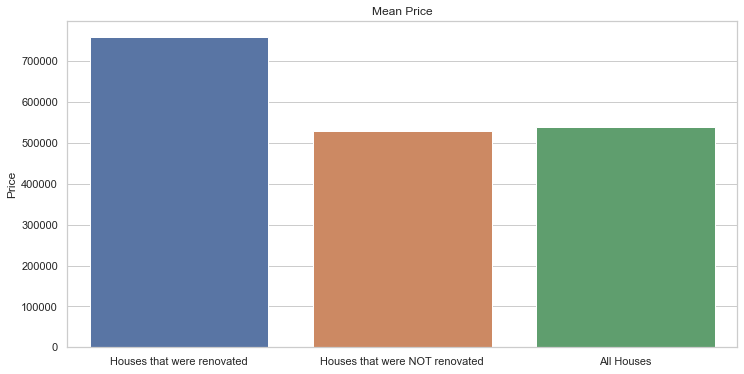

In [199]:
sns.barplot(x=['Houses that were renovated', 'Houses that were NOT renovated', 'All Houses'], y=[renovated['price'].mean(), not_renovated['price'].mean(), df3['price'].mean()]);
plt.title('Mean Price');
plt.ylabel('Price');

In [200]:
df3['renovated'] = df3['year_renovated'].apply(lambda x: 'renovated' if x != 0 else 'not_renovated')

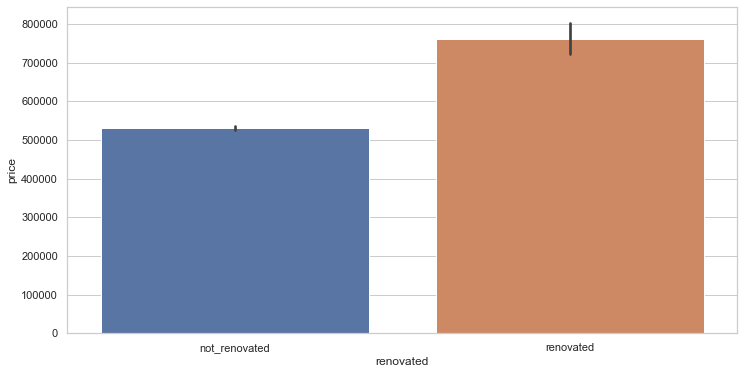

In [201]:
sns.barplot(data=df3, x='renovated', y='price');

In [202]:
len(renovated)

914

In [203]:
len(df3[df3['year_renovated'] == 0])

20698

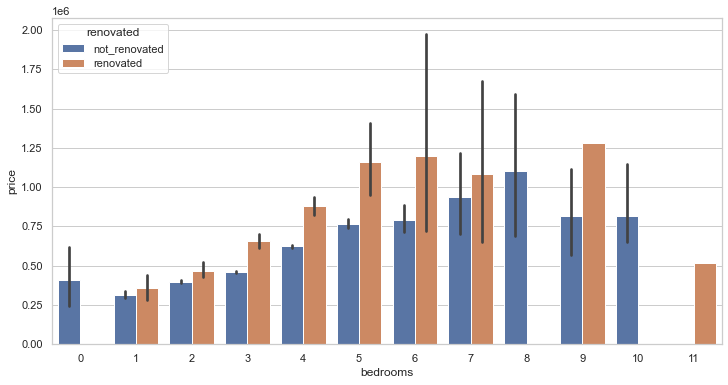

In [204]:
sns.barplot(data=df3, x='bedrooms', y='price', hue='renovated');

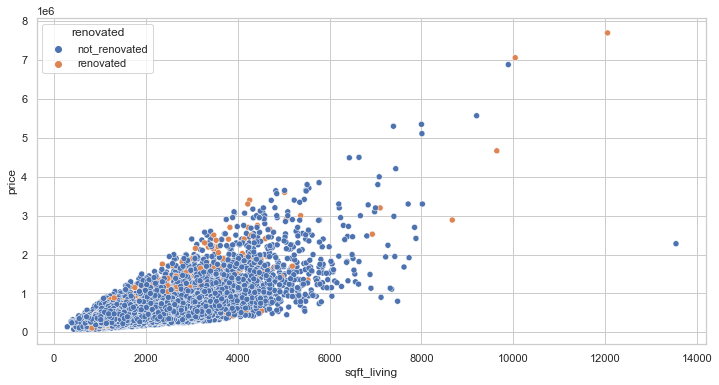

In [205]:
sns.scatterplot(data=df3, x='sqft_living', y='price', hue='renovated');

In [ ]:
sns.barplot(data=df3, x='sqft_lot', y='price', hue='renovated');